<a href="https://colab.research.google.com/github/eflatlan/CNN_PID/blob/models_sacved/most_recent_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install h5py numpy

import os
import h5py
import numpy as np

from google.colab import drive
drive.mount('/content/drive')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/dev_floatmap/helper_functions.py
#from helper_functions.py import print_points, plot_mapsm

In [12]:

def calc_dist2mip(maps = None,  mip_positions = None, resolution = 10):
#        X_dist2mip = calc_dist2mip(maps = X_map, mip_positions = X_mip_position, resolution = resolution)

    length = maps.shape[0]
    distances_map_list = []



    #i = 0
    for i in range (length):

        map = np.array(maps[i, :,:])
        mip_pos = np.array(mip_positions[i, :]).copy()

        #print(f"filled_bins shape = {filled_bins.shape}")
        #print(f"map shape = {map.shape}")
        #print(f"mip_pos shape = {mip_pos.shape}")

        _mip_position = []


        # start vectorization
        # Assuming your map is a numpy array
        indices = np.where(map == 1)

        # Now indices[0] contains the y-indices and indices[1] contains the x-indices
        points = np.stack(indices, axis=-1)  # Shape is [num_points, 2]
        mip_pos = np.array([mip_pos[1], mip_pos[0]]) * resolution
        distances = np.linalg.norm(points - mip_pos, axis=-1)
        distances = distances[distances < 20*resolution]  # Filter out large distances
                                                          # later do this instead by imposing the masshypothesis
        # end vectorization

      
      
        distances_map_list.append(distances)
      
    #distances_map_list.append(temp)


    print(f"maps shape = {maps.shape}")
    print(f"mip_position_array shape = {mip_positions.shape}")
    print(f"distances_map_list shape = {np.array(distances_map_list, dtype=object).shape}")

    return distances_map_list

In [13]:
import math
import numpy
class Constants:
    def __init__(self):
        self.defaultPhotonEnergy = 6.75
        self.CH4GapWidth = 8.0
        self.RadiatorWidth = 1.0
        self.QuartzWindowWidth = 0.5
        self.EmissionLength = self.RadiatorWidth / 2.0

class Masses:
    def __init__(self):
        self.mass_Pion = 0.1396
        self.mass_Kaon = 0.4937
        self.mass_Proton = 0.938


# Create constants and masses objects outside of CkovCalculator
constants = Constants()
masses = Masses()



class CkovCalculator:
    #def __init__(self):
        #self.constants = constants
        #self.masses = masses

    def GetFreonIndexOfRefraction(self, photonEnergy):
        x = photonEnergy
        k = 1.177 + (0.0172) * x
        return k


    # TODO : replace this and getRadiusFromCkov with instead accepting #
    #         refractive-index or phtoton energy as inputs to calculate the refIndex
    def get_ckov_from_radius(self, radius, resolution):
        """
        Args : array or scalar of radiuses, 
        Returns : ckovAngles
        """
        refIndexFreon = self.GetFreonIndexOfRefraction(constants.defaultPhotonEnergy)
        refIndexQuartz = self.GetQuartzIndexOfRefraction(constants.defaultPhotonEnergy)
        qz = constants.QuartzWindowWidth * refIndexFreon / refIndexQuartz
        ch4 = constants.CH4GapWidth * refIndexFreon / 1 # refIndexCh4 = 1
        ckov = constants.RadiatorWidth - constants.EmissionLength

        # radius = num_samples X padded_length
        radius = numpy.asarray(radius, dtype = object)/resolution

        print(f"get_ckov_from_radius shape of radius = {radius.shape}")

        # Assuming `radius` is a 2D NumPy array with shape (num_samples, some_length)
        first_column = radius[0, :]  # Extract the first column

        binwidth = 0.1
        bins = np.arange(0, 80 + binwidth, binwidth)

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        try:
          axs[0].hist(first_column, bins=bins)
          axs[0].set_xlabel('Radius')
          axs[0].set_ylabel('Frequency')
          axs[0].set_title('Histogram of Radius (First Column)')
          axs[0].legend()
        except Exception as e:
          print(f" failed at plotting radius histogram with error {e}")

        binwidth = 0.1
        bins = np.arange(0.5, 10 + binwidth, binwidth)

        try:
          axs[1].hist(first_column, bins=bins)
          axs[1].set_xlabel('Radius')
          axs[1].set_ylabel('Frequency')
          axs[1].set_title('Adj Histogram of Radius (First Column)')
        except Exception as e:
          print(f" failed at plotting adjusted radius histogram with error {e}")
        plt.show()

        print(f"Max value in radius: {np.max(radius)}")
        print(f"Min value in radius: {np.min(radius)}")

        print(f"qz {qz} ch4 {ch4} + ckov {ckov}")

        sin_ckov_angle = np.asarray(radius /((qz + ch4 + ckov)), dtype=object)
        binwidth = 0.1

        fig2, axs2 = plt.subplots(1, 2, figsize=(16, 8))
        try:
          axs2[0].hist(sin_ckov_angle, bins = 100)
          axs2[0].set_xlabel('Sin ckov')
          axs2[0].set_ylabel('Frequency')
          axs2[0].set_title('Histogram of sin ckov')
          axs2[0].legend()
        except Exception as e:
          print(f" failed at plotting sin-ckov angle histogram with error {e}")

        print(f"Max value in radius: {np.max(radius)}")
        print(f"Min value in radius: {np.min(radius)}")
        sin_ckov_angle = np.where((sin_ckov_angle >= 0.1) & (sin_ckov_angle <= 1), sin_ckov_angle, 0)
        sin_ckov_angle = np.nan_to_num(sin_ckov_angle, nan=0)

        binwidth = 0.01
        bins = np.arange(0.05, 1 + binwidth, binwidth)

        try:
          axs2[1].hist(sin_ckov_angle, bins=bins)
          axs2[1].set_xlabel('Sin ckov')
          axs2[1].set_ylabel('Frequency')
          axs2[1].set_title('Adj Histogram of sin ckov')
        except Exception as e:
          print(f" failed at plotting adjusted sin-ckov angle histogram with error {e}")
        plt.show()

        print(f"Max value in radius: {numpy.max(radius)}")
        print(f"Min value in radius: {numpy.min(radius)}")


        print(f"Max value in sin_ckov_angle: {numpy.max(sin_ckov_angle)}")
        print(f"Min value in sin_ckov_angle: {numpy.min(sin_ckov_angle)}")

        if numpy.any(sin_ckov_angle > 1) or numpy.any(sin_ckov_angle < -1):
            print("Invalid values present for arcsin function")        

        ckov_angle = numpy.arcsin(sin_ckov_angle.astype(float))

        print(f"get_ckov_from_radius shape of ckov_angle = {ckov_angle.shape}")

        return ckov_angle 


    def GetQuartzIndexOfRefraction(self, x):
        k = math.sqrt(1 + 46.411 / (113.763556 - x) + 228.71 / (328.51563 - x))
        return k

    def getRadiusFromCkov(self, ckovAngle):
        """
        Args : array or scalar of ckovAngles, 
        Returns : radiuses
        """
        refIndexFreon = self.GetFreonIndexOfRefraction(constants.defaultPhotonEnergy)
        refIndexQuartz = self.GetQuartzIndexOfRefraction(constants.defaultPhotonEnergy)
        refIndexCH4 = 1.0

        sin_ckov = np.sin(ckovAngle)
        sin_qz = sin_ckov * (refIndexFreon / refIndexQuartz)
        sin_theta0 = sin_qz * (refIndexQuartz / refIndexCH4)

        R_ckov = sin_ckov * (constants.RadiatorWidth - constants.EmissionLength)
        R_qz = sin_qz * constants.QuartzWindowWidth
        R_0 = sin_theta0 * constants.CH4GapWidth

        R = R_ckov + R_qz + R_0
        return R

    def calcCkovFromMass(self, p, n):
        p_sq = p * p
        cos_ckov_denom = p * n

        radiuses = {}

        for particle, mass in masses.__dict__.items():
            # Skip non-mass attributes
            if not particle.startswith("mass"):
                continue

            mass_value = getattr(masses, particle)

            # sanity check
            if p_sq + mass_value * mass_value < 0:
                radiuses[particle] = 0.0
                continue

            cos_ckov = math.sqrt(p_sq + mass_value * mass_value) / cos_ckov_denom

            # sanity check
            if cos_ckov > 1 or cos_ckov < -1:
                radiuses[particle] = 0.0
                continue

            ckovAngle = math.acos(cos_ckov)
            radius = self.getRadiusFromCkov(ckovAngle)
            radiuses[particle] = radius
            #print(f"{particle} mass_value = {mass_value} Radius: {radius} ckov = {ckovAngle} momentum = {p} refindex = {n}")

        return radiuses
        

In [14]:
def calc_ckov_hyp(p, n):
  """
    Args  : vectors of momentum and refIndex, 

    Returms : numsaplesx3 array, where for eacj num_samples,
              the hypothetical expected ckov angle would be 
              calculated based on mass_{Pion, Kaon, Proton}

    NB! If momentum is too low, it might be possible that Kaons and Protons 
        Not can be inverted from the mass-hypothesis
        i.e., we can not take the acos of : cos(ckov)= sqrt(p*p+m^2)/(p*n)
  """

  try:
    p = np.asarray(p).reshape(len(p), 1)
    n = np.asarray(n).reshape(len(n), 1)

    p_sq = np.square(p)

    cos_ckov_denom = np.multiply(p, n)
  except Exception as e : 
    print(f"calc_ckov_hyp failed with {e}")

  print(f"p shape = {p.shape}")
  print(f"n shape = {n.shape}")

  print(f"cos_ckov_denom shape = {cos_ckov_denom.shape}")
  # mass_pion, kaon, proton
  cos_ckov = np.zeros((len(cos_ckov_denom),3))

  mass_values = np.array([0.1396, 0.4937, 0.938])
  p_sq = p_sq.reshape(-1, 1)  # reshape p_sq to shape (2444, 1)
  mass_values_squared = np.square(mass_values).reshape(1, -1)  # reshape mass_values_squared to shape (1, 3)

  cos_ckov_denom = cos_ckov_denom.reshape(-1, 1)  # reshape cos_ckov_denom to shape (2444, 1)

  cos_ckov = np.sqrt(p_sq + mass_values_squared) / cos_ckov_denom
  
  #cos_ckov = cos_ckov.reshape(-1, 1)  # reshape cos_ckov_denom to shape (2444, 1)

  print(f"cos_ckov_denom shaoe = {cos_ckov_denom.shape} | should be n*1")

  print(f"cos_ckov shape = {cos_ckov.shape} should be n * 3")
  cos_ckov = (cos_ckov).reshape(len(cos_ckov), 3)  # reshape mass_values_squared to shape (1, 3)
  print(f"cos_ckov shape = {cos_ckov.shape} should be n * 3")

  invalid_indexes = np.where((cos_ckov > 1) | (cos_ckov < -1))


  print(f"invalid_indexes shaoe = {np.asarray(invalid_indexes, dtype = object).shape} | should be 2*k")

  if invalid_indexes[0].size > 0:
    print("calc_ckov_hyp() : Invalid values present for arccos function. Invalid indices are:")
    # for index in range(len(invalid_indexes[0])):
    #     print(f'Index : {index} : cos_ckov Values : {invalid_indexes[0][index], invalid_indexes[1][index]}: {cos_ckov[invalid_indexes[0][index], invalid_indexes[1][index]]}')
    #     try:
    #       print(f'Index : {index} : cos_ckov Values : {invalid_indexes[index][0], invalid_indexes[index][1] , invalid_indexes[index][1]}')
    #     except Exception as e :
    #       print(f"failed gettting invalid indexes with error : {e}")

    #     try :
    #        #print(f" p_sq = {p_sq[invalid_indexes[0][index]]}")
    #        print(f" p_sq = {p_sq[invalid_indexes[0][index]]} mass_values_squared = {mass_values_squared},"
    #              "cos_ckov_denom[i] = {cos_ckov_denom[invalid_indexes[0][index]]} Formula : "
    #              "cos(ckov)= sqrt(p*p+m^2)/(p*n)")
    #     #set all nonvalid values to 0:
    #     except Exception as e :
    #       print(f"failed gettting invalid indexes with error : {e}")
          
  cos_ckov = numpy.where((cos_ckov >= 0.1) & (cos_ckov <= 1), cos_ckov, 0)
  cos_ckov = numpy.nan_to_num(cos_ckov, nan=0)


  # values where the theta_{p, K, proton} is not cos-invertible will be set to 0
  ckovAngles = np.arccos(cos_ckov)
  return ckovAngles

def segment_photons(cherenkov_photon_candidates = None, ckov_hyp = None):
    """
    Args : 
        cherenkov_photon_candidates : vector of num_samples x padded_length, 
            where for each n in num_samples the padded_length is the number of photon cherenkov candidates
            in the n in num_samples with highest n of photon cherenkov candidates

        ckov_hyp : a vector of num_samples x 3, 
            where for each n in num_samples we have the potential Cherenkov Photon 
            Values based on the ref-index, momentum and mass_{pion, kaon, proton}

            If the value for cos(ckov) = sqrt(p^2+m_i^2)/(p*n) fpr m_i = {mass_pi, mass_K, mass_proton}
            Not is invertible, its value in the ckov_hyp array is set to 0

    Returns : 
          segmented_photons : An array of num_samples x 3, where for each num_samples, the elements 1, 2, 3 will have the photon_candidates within a certain band around the ckov_angles from mass_{pion, kaon, proton},
              Applying a cutoff at a TBD threshold (e.g., +-2*std.dev)             
    """
    # shape = (num_samples, 3)
    cherenkov_photon_candidates = np.asarray(cherenkov_photon_candidates)

    ckov_hyp = np.asarray(ckov_hyp)

    print(f"segment_photons : cherenkov_photon_candidates shape = {cherenkov_photon_candidates.shape}"
            f", ckov_hyp shape = {ckov_hyp.shape}")
    # ex: segment_photons : cherenkov_photon_candidates shape = (2444, 74), ckov_hyp shape = (2444, 3)

    # Standard deviation
    std_dev = 0.01 # just initial value, this can be trained or set empirically

    # Extend dimensions for broadcasting
    cherenkov_photon_candidates = cherenkov_photon_candidates[:, np.newaxis, :]
    ckov_hyp = ckov_hyp[:, :, np.newaxis]


    print(f"segment_photons : cherenkov_photon_candidates shape = {cherenkov_photon_candidates.shape}"
            f", ckov_hyp shape = {ckov_hyp.shape}")
    # compute the mask for values within the std_dev range
    mask = (cherenkov_photon_candidates >= ckov_hyp - std_dev) & (cherenkov_photon_candidates <= ckov_hyp + std_dev)

    # apply mask
    segmented_photons = cherenkov_photon_candidates * mask


    print(f"segment_photons : mask shape = {mask.shape}"
            f", segmented_photons shape = {segmented_photons.shape}")
    

    # --- Figure 1: Histograms for the first element in num_samples ---
    fig1, axs1 = plt.subplots(1, 3, figsize=(18, 6))


    strings_desc = ["pion", "kaon", "proton"]
    # Create histogram for each array in the 3 x length_of_variables structure
    for i in range(3):
        axs1[i].hist(segmented_photons[0, i, :], bins=np.arange(0.1, 0.8, 0.01), edgecolor='black')
        axs1[i].set_title(f'Histogram of Segmented Photons {strings_desc[i]}')
        axs1[i].set_xlabel('Value')
        axs1[i].set_ylabel('Frequency')

    fig1.tight_layout()
    #lt.show()



    # --- Figure 2: Histograms of all elements in segmented_photons (num_samples) ---
    fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6))


    # Create histogram for each array across all num_samples
    for i in range(3):
        flattened_data = segmented_photons[:, i, :].flatten()
        axs2[i].hist(flattened_data, bins=np.arange(0.05, 0.8, 0.01), edgecolor='black')
        axs2[i].set_title(f'Histogram for Segmented Photons {strings_desc[i]} (All num_samples)')
        axs2[i].set_xlabel('Value')
        axs2[i].set_ylabel('Frequency')

    fig2.tight_layout()
    #plt.show()

    # --- Figure 3: Histograms for all elements in num_samples ---

    # i want n_rows = 3, n_cols = 2
    fig3, axs3 = plt.subplots(2, 3, figsize=(18, 12))


    # Create histogram for each array across all num_samples 
    # in    ckov_hyp = (2444, 3, 74) # ns x 3 x padded_length

    for i in range(3):
        flattened_data = ckov_hyp[:, i, :].flatten()
        axs3[0, i].hist(flattened_data, bins=np.arange(0, 0.8, 0.01), edgecolor='black')
        axs3[0, i].set_title(f'Histogram for Ckov Hyp {strings_desc[i]} (All num_samples)')
        axs3[0, i].set_xlabel('Value')
        axs3[0, i].set_ylabel('Frequency')

        axs3[1, i].hist(flattened_data, bins=np.arange(0.1, 0.8, 0.01), edgecolor='black')
        axs3[1, i].set_title(f'Histogram for Ckov Hyp {strings_desc[i]} (All num_samples)')
        axs3[1, i].set_xlabel('Value')
        axs3[1, i].set_ylabel('Frequency')

    fig3.tight_layout()

    for ax in axs1.flatten():
        ax.set_aspect('equal')
        
    # for ax in axs2.flatten():
    #     ax.set_aspect(1)
        
    # for ax in axs3.flatten():
    #     ax.set_aspect(1)

    plt.show()


    # Initialize counters for nan and zero values
    count_nans = np.zeros(3, dtype=int)
    count_zeros = np.zeros(3, dtype=int)



    # Count occurrences of nan and zero values for each of the 3 arrays
    for i in range(3):
        count_nans[i] = np.isnan(segmented_photons[:, i, :]).sum()
        count_zeros[i] = np.count_nonzero(segmented_photons[:, i, :] == 0)

    print("Counts of nan values for each array: ", count_nans)
    print("Counts of zero values for each array: ", count_zeros)

    # replace zeros with np.nan
    #segmented_photons[segmented_photons == 0] = np.nan

    return segmented_photons





In [15]:
#@title Default title text
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import os
import h5py
import tensorflow as tf

# to check the impact of resolution in the 2d-map; 
# print the difference between the filledBins vector versus the map (map is restricted by resolution)
def print_points(filled_bins_array = None, map_array = None, mip_position_array = None, resolution = 10):

    length = map_array.shape[0]
    distances_bins_list = []
    distances_map_list = []

    print(f"filled_bins_array shape = {filled_bins_array.shape}")
    print(f"map_array shape = {map_array.shape}")
    print(f"mip_position_array shape = {mip_position_array.shape}")


    for i in range (1, length):

        filled_bins = np.array(filled_bins_array[i])
        map = np.array(map_array[i, :,:])
        mip_pos = np.array(mip_position_array[i, :])

        #print(f"filled_bins shape = {filled_bins.shape}")
        #print(f"map shape = {map.shape}")
        #print(f"mip_pos shape = {mip_pos.shape}")

        _mip_position = []
        #_mip_position.append(mip_position_array[])
        distances2 = []

        distances_bins = [norm(np.array(pos) - mip_pos) for pos in filled_bins]

        distances_map = []
        for y in range(map.shape[0]):
            for x in range(map.shape[1]):
                if map[y, x] == 1:
                    point = (x, y)
                    distance = np.linalg.norm(np.array(point) - mip_pos*resolution)
                    distances_map.append(distance)
        
        
        
        distances_bins_list.append(distances_bins)
        distances_map_list.append(distances_map)


    # Print the distances for each element in map_data_list
    print(f"Element {i+1} distances:")
    for j, (distances_bins, distances_map) in enumerate(zip(distances_bins_list, distances_map_list)):
        print(f"  Point {j+1}: Distance bins: {distances_bins}\n, Distance map: {distances_map}")
    print()




def plot_maps(filled_bins_array=None, map_array=None, mip_position_array=None, X_momentum=None, X_refractive_index=None, X_ckov=None, percentage_to_plot=5, resolution = 10):
  """
  Args : filled_bins_array : array that holds the vectors of filled pads 
         map_array : 2d  map with a determined resolution (the points in the filled_bins_array element, just restricted by the resolution)
         mip_position_array : array of the MIP {x, y} positions

         TODO : add mass_category and actual mass?
  """
  

  #percentage_to_plot = 0.05 / 10

  # Calculate the starting index of the samples to plot
  num_samples = map_array.shape[0]
  start_index = -num_samples

  # Create a subplot with the number of rows based on the number of samples
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))

  # Iterate over the samples and plot each map with information
  for i, ax in enumerate(axes):
      # Get the map and corresponding information
      map_data = map_array[start_index + i, :, :]
      #mass_category = particle_vector[start_index + i].mass_category
      ckov = X_ckov[start_index + i]
      mip_position = mip_position_array[start_index + i]
      momentum = X_momentum[start_index + i]
      refractive_index = X_refractive_index[start_index + i]

      # Plot the map
      ax.imshow(map_data, cmap='gray')



      #try :
      # Add a red dot at the MIP position
      ax.plot(mip_position[0]*resolution, mip_position[1]*resolution, 'ro')
      #Except exception as e : 
      #  print("caught non mip pos ")
      # Set the title with the information
      #ax.set_title(f"Mass: {mass_category}, CKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum},  refractive_index: {refractive_index}")
      ax.set_title(f"CKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum},  refractive_index: {refractive_index}")

      ax.axis('off')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()

In [16]:
def create_lr_scheduler(num_epochs = 10):

  start_lr = 0.1
  end_lr = 5e-6
  exp_decay = -np.log(end_lr/start_lr) / num_epochs # Calculate decay rate based on start and end learning rate

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: start_lr * np.exp(-exp_decay * epoch)) 
  return lr_scheduler



def plot_lr(num_epochs = 10, history = None):
  div = num_epochs/4
  lrs = 1e-4 * (10 ** (np.arange(num_epochs)/div))
  plt.figure(figsize=(10, 7))
  plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
  plt.xlabel("Learning Rate")
  plt.ylabel("Loss")


  plt.title("Learning rate vs. loss");

#z!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py

from plot_helper_functions import plot_training_history, plot_dist2mip_histograms
#from plot_helper_functions.py import plot_training_history, plot_dist2mip_histograms, plot_maps


--2023-05-26 11:47:11--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11062 (11K) [text/plain]
Saving to: ‘plot_helper_functions.py.1’

plot_helper_functio 100%[===================>]  10.80K  --.-KB/s    in 0s      

2023-05-26 11:47:11 (23.3 MB/s) - ‘plot_helper_functions.py.1’ saved [11062/11062]



In [17]:
#def plot_worst_(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
def plot_maps(filled_bins_array=None, map_array=None, mip_position_array=None, X_momentum=None, X_refractive_index=None, X_ckov=None, percentage_to_plot=5, resolution = 10):
  #  print("Shape of y_pred: ", y_pred.shape)
  # 1. Predict labels on validation data
  #plot_worst(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], y_pred_test)

  # 2. Calculate the difference between predicted and actual labels
  losses = tf.keras.losses.categorical_crossentropy(y_test, y_pred).numpy()

  # Sort the indices of the losses from highest to lowest
  sorted_indices = np.argsort(losses)[::-1]

  # Get the indices of the worst performing 10%
  worst_10_percent_indices = sorted_indices[:int(0.1*len(sorted_indices))]

  # Create figure and axes
  num_plots = len(worst_10_percent_indices)
  #fig, axes = plt.subplots(num_plots, 1, figsize=(8, 20))
  fig, axes = plt.subplots(num_plots,figsize=(8, 20))

  # Define mass categories
  mass_categories = ["pion", "kaon", "proton"]

  # 3. Create plots for these cases, including their feature information and predicted vs actual labels
  for i, index in enumerate(worst_10_percent_indices):
      # Get the map and corresponding information
      map_data = map_array[index, :, :]
      actual_mass_category = mass_categories[np.argmax(y_test[index])]

      print(f"y_test[index] = {y_test[index]}")

      predicted_mass_category = mass_categories[np.argmax(y_pred[index])]
      ckov = X_test_ckov[index]
      mip_position = X_test_mip_position[index]
      momentum = X_test_momentum[index]
      refractive_index = X_test_refractive_index[index]
      
      mass_actual = momentum * np.sqrt(refractive_index**2 * np.cos(ckov)*np.cos(ckov) - 1)
      
      # Check if the value is NaN (invalid Cherenkov angle)
      if np.isnan(mass_actual):
          mass_actual = "Invalid"

      # Plot the map
      axes[i].imshow(map_data, cmap='gray')

      # Add a red dot at the MIP position
      axes[i].plot(mip_position[0]*resolution, mip_position[1]*resolution, 'ro')

      # Set the title with the information
      axes[i].set_title(f"Actual Mass")#: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")
      #
      axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")

      #axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category}, Mass: {mass_actual}\nCKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum}, Refractive Index: {refractive_index}")
      axes[i].axis('off')

      print("\n")
      print(f"  Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\n Mass: {mass_actual}, Mass_prob = {y_pred[index]} \n CKOV: {ckov}, MIP Position: {mip_position}, \n  Momentum: {momentum}, Refractive Index: {refractive_index}")
  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()


In [18]:
def create_circular_mask(center, size, mean_radius, std):
    H, W = size
    Y, X = np.ogrid[:H, :W]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = (dist_from_center >= mean_radius - 2*std) & (dist_from_center <= mean_radius + 2*std)
    return mask


def extract_segment_around_mip(mip_positions = None, window_sizes = None, maps = None, std = 7):
    """
    Args : mip_positions : array of the MIP-positions, (num_samples, {x, y})
           window_sizes : radius of the segments (num_samples, 3) 3 = number of particle classes
           maps : the photon hit-maps (num_samples, 144*resolution, 160*resolution)
           std : standard deviatons to be applied to the ring-radius 
           
    Returns : the extracted regions for each of the different radiuses (m_pion, m_kaon, m_proton), masked with the map
    """
    
    windows = []

    for mip_position, window_size, map in zip(mip_positions, window_sizes, maps):
        radius = np.mean(window_size)
        #std = np.std(window_size)

        mask = create_circular_mask(mip_position, map.shape, radius, std)

        window = np.where(mask, map, 0)

        windows.append(window)

    return np.array(windows)


1000
load_data : reading file ParticleInfoLead.h5
load_data : location /content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/
Number of particles: 2444
plot_maps failed due to error : name 'y_test' is not defined
maps shape = (2444, 576, 640)
mip_position_array shape = (2444, 2)
distances_map_list shape = (2444,)
p shape = (2444, 1)
n shape = (2444, 1)
cos_ckov_denom shape = (2444, 1)
cos_ckov_denom shaoe = (2444, 1) | should be n*1
cos_ckov shape = (2444, 3) should be n * 3
cos_ckov shape = (2444, 3) should be n * 3
invalid_indexes shaoe = (2, 108) | should be 2*k
calc_ckov_hyp() : Invalid values present for arccos function. Invalid indices are:
get_ckov_from_radius shape of radius = (2444, 74)


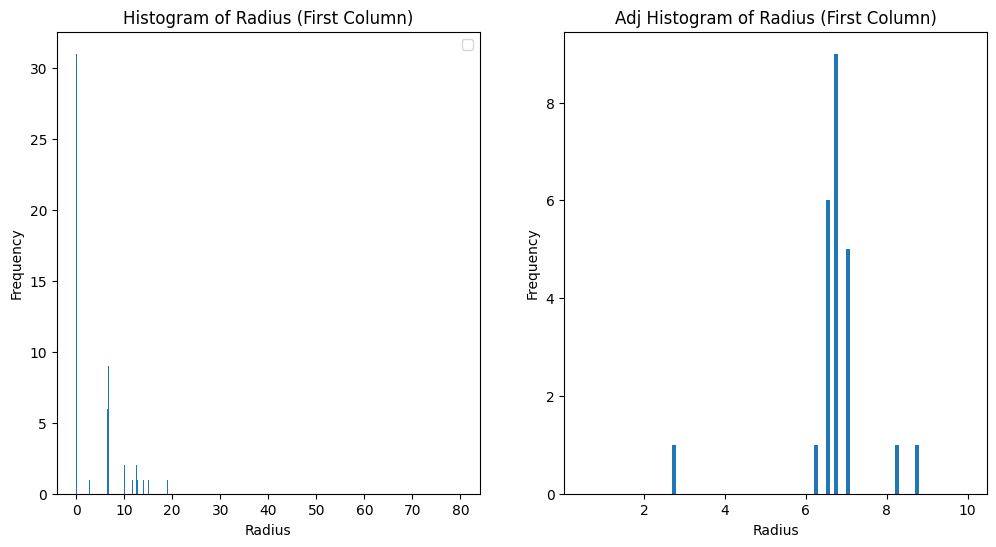

Max value in radius: 19.75
Min value in radius: 0.0
qz 0.4415095946430371 ch4 10.344800000000001 + ckov 0.5


Max value in radius: 19.75
Min value in radius: 0.0


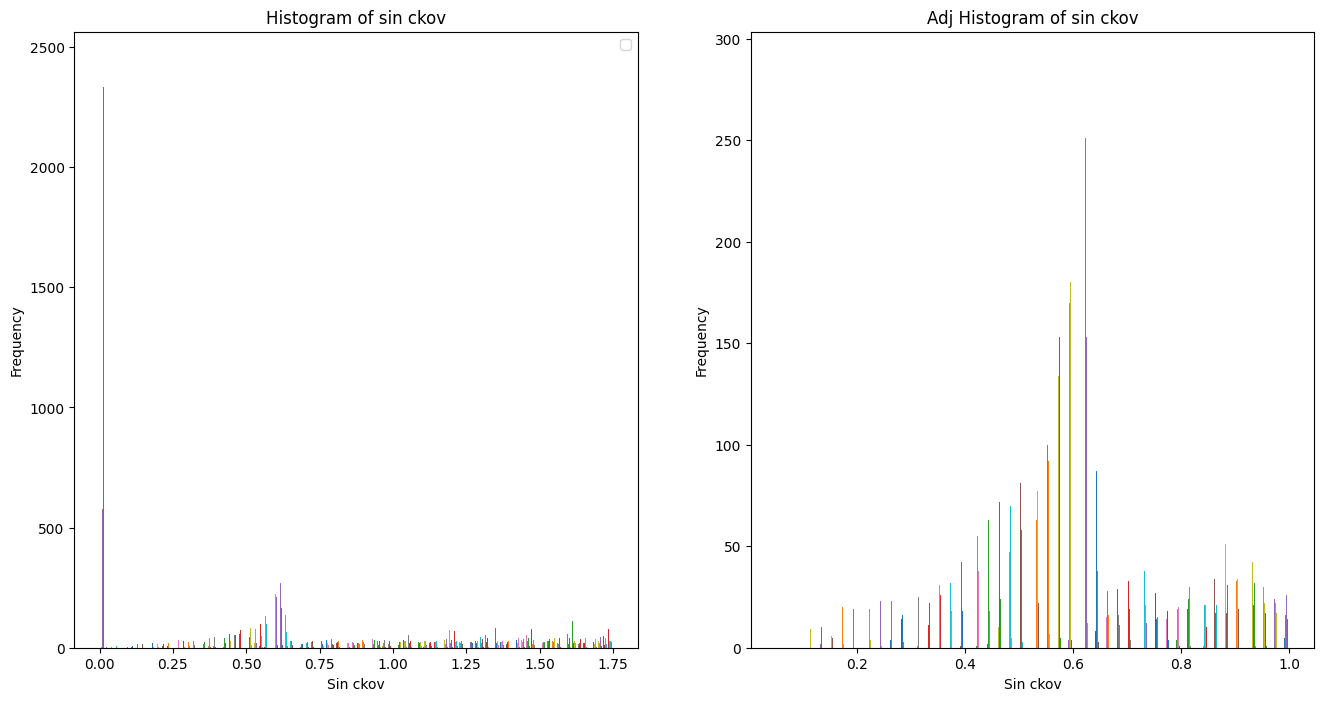

Max value in radius: 19.75
Min value in radius: 0.0
Max value in sin_ckov_angle: 0.9967828638459225
Min value in sin_ckov_angle: 0
get_ckov_from_radius shape of ckov_angle = (2444, 74)
segment_photons : cherenkov_photon_candidates shape = (2444, 74), ckov_hyp shape = (2444, 3)
segment_photons : cherenkov_photon_candidates shape = (2444, 1, 74), ckov_hyp shape = (2444, 3, 1)
segment_photons : mask shape = (2444, 3, 74), segmented_photons shape = (2444, 3, 74)


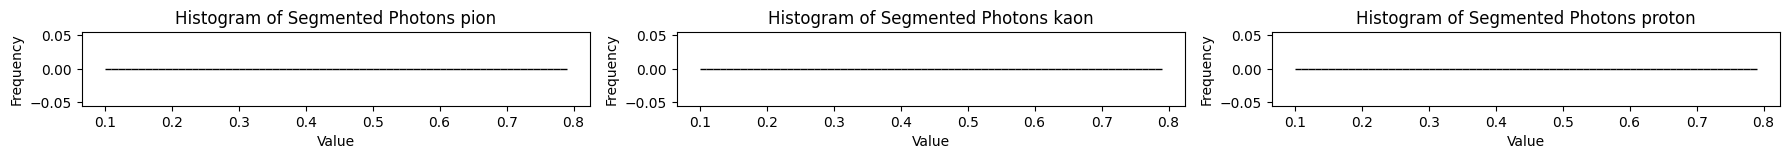

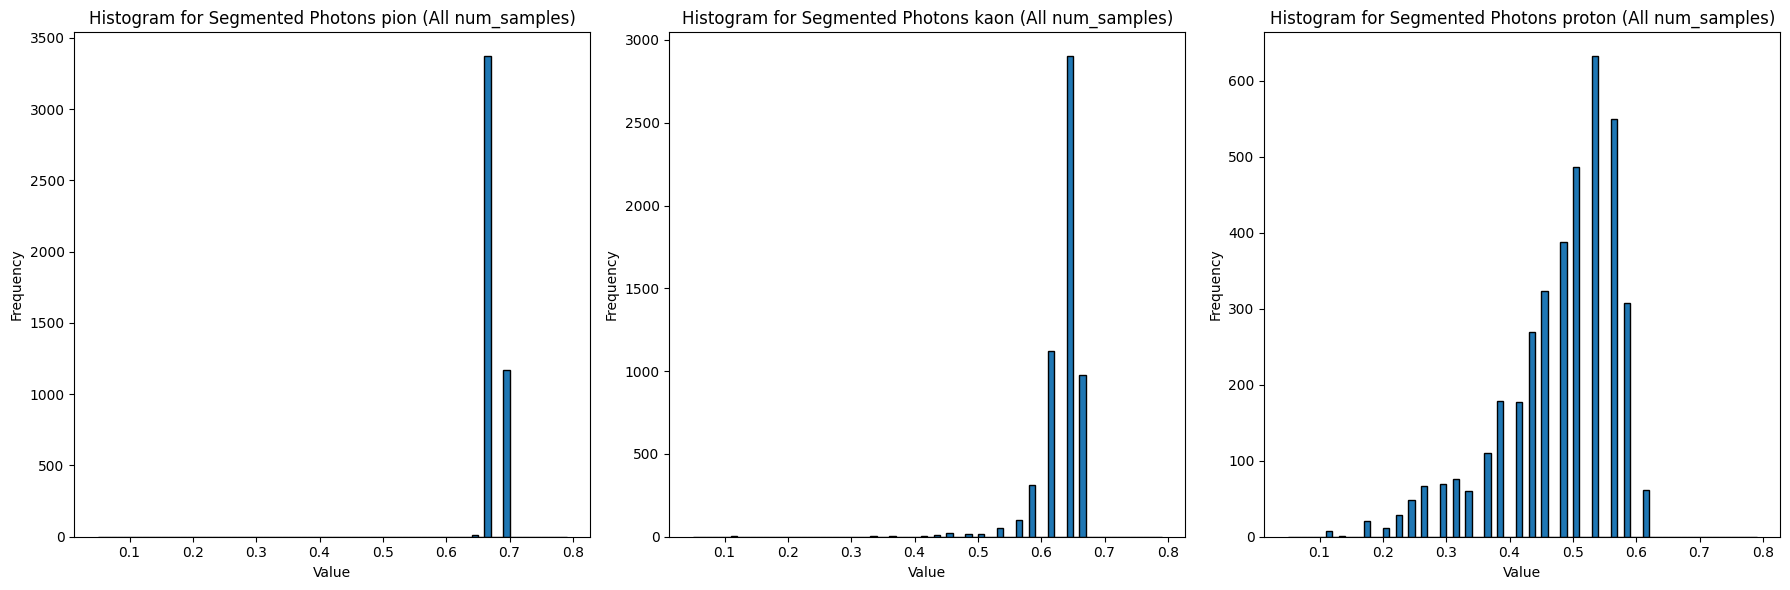

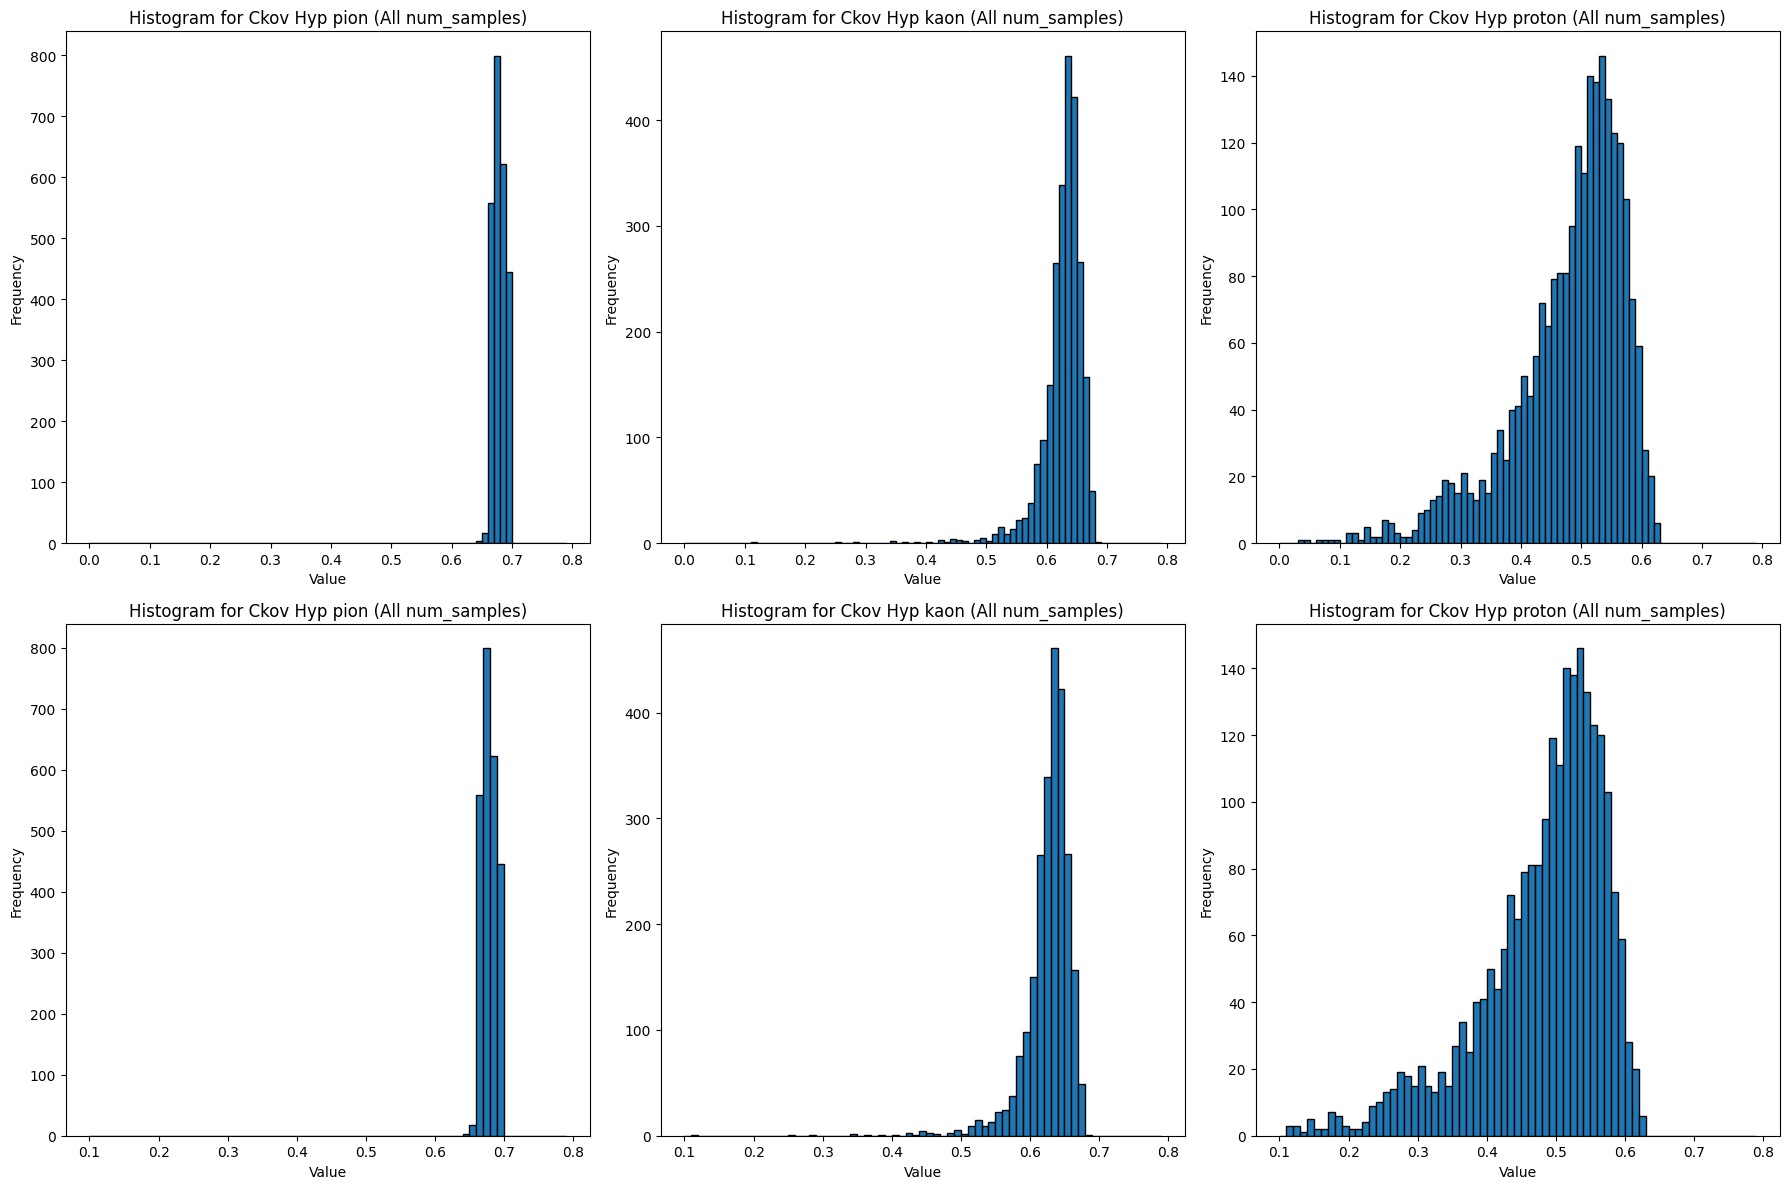

Counts of nan values for each array:  [0 0 0]
Counts of zero values for each array:  [176307 175296 176980]
 in  def train(self, filename) : X_train_photon_ckov_segmented shape : (1955, 3, 74)
plot_maps failed due to error : name 'y_test' is not defined
maps shape = (2444, 576, 640)
mip_position_array shape = (2444, 2)
distances_map_list shape = (2444,)
p shape = (2444, 1)
n shape = (2444, 1)
cos_ckov_denom shape = (2444, 1)
cos_ckov_denom shaoe = (2444, 1) | should be n*1
cos_ckov shape = (2444, 3) should be n * 3
cos_ckov shape = (2444, 3) should be n * 3
invalid_indexes shaoe = (2, 108) | should be 2*k
calc_ckov_hyp() : Invalid values present for arccos function. Invalid indices are:
get_ckov_from_radius shape of radius = (2444, 74)


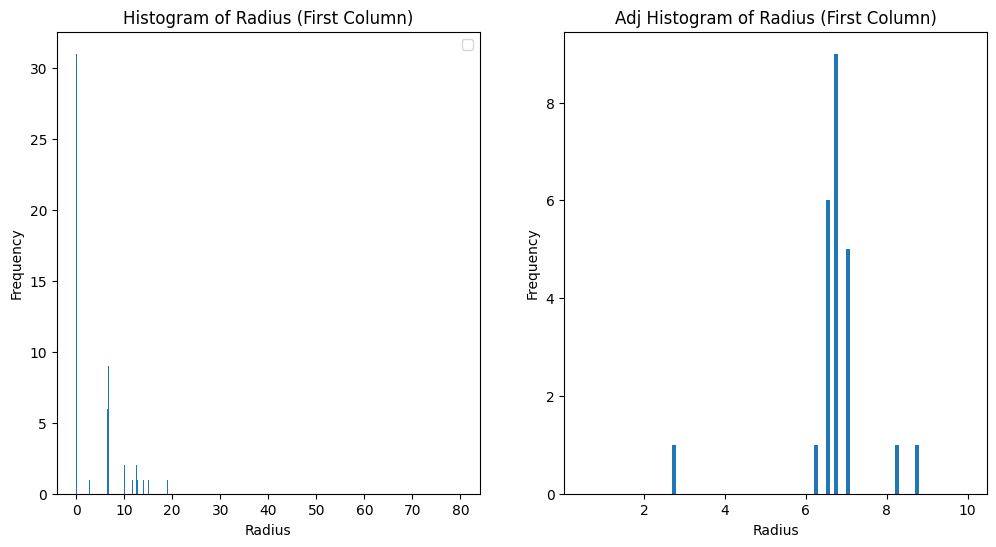

Max value in radius: 19.75
Min value in radius: 0.0
qz 0.4415095946430371 ch4 10.344800000000001 + ckov 0.5


Max value in radius: 19.75
Min value in radius: 0.0


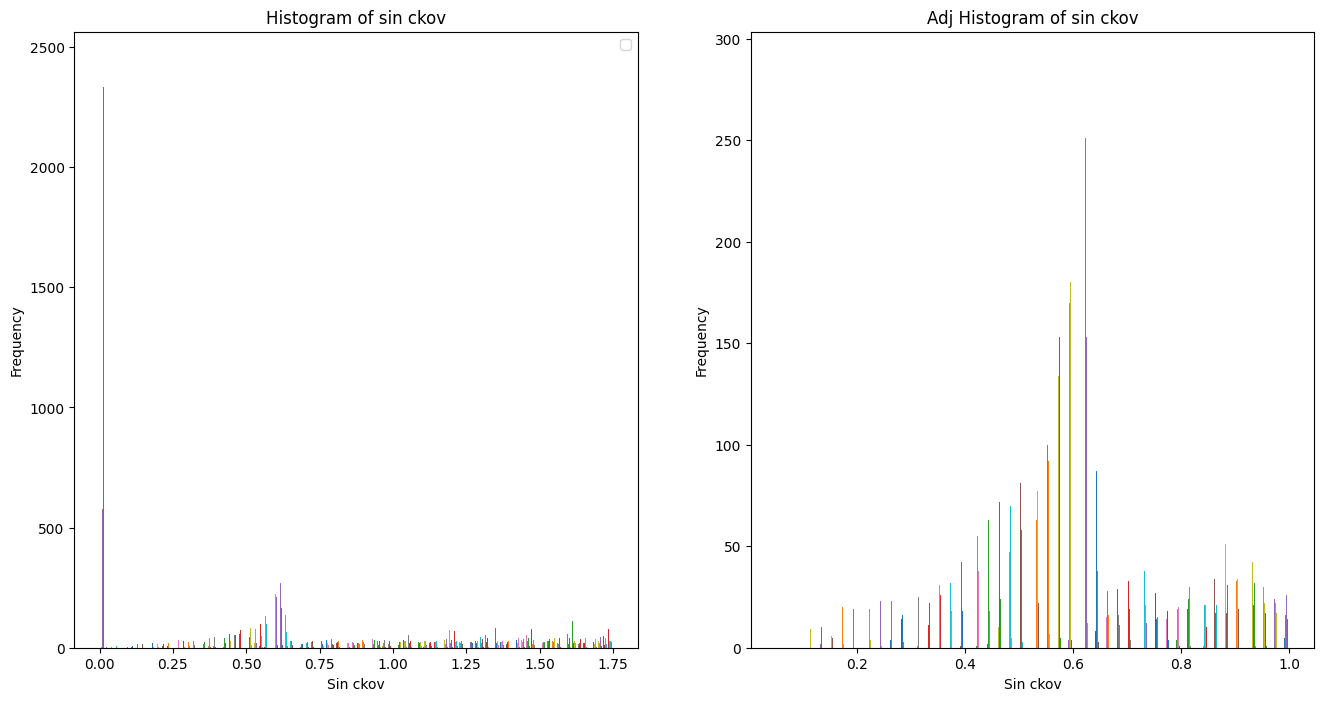

Max value in radius: 19.75
Min value in radius: 0.0
Max value in sin_ckov_angle: 0.9967828638459225
Min value in sin_ckov_angle: 0
get_ckov_from_radius shape of ckov_angle = (2444, 74)
segment_photons : cherenkov_photon_candidates shape = (2444, 74), ckov_hyp shape = (2444, 3)
segment_photons : cherenkov_photon_candidates shape = (2444, 1, 74), ckov_hyp shape = (2444, 3, 1)
segment_photons : mask shape = (2444, 3, 74), segmented_photons shape = (2444, 3, 74)


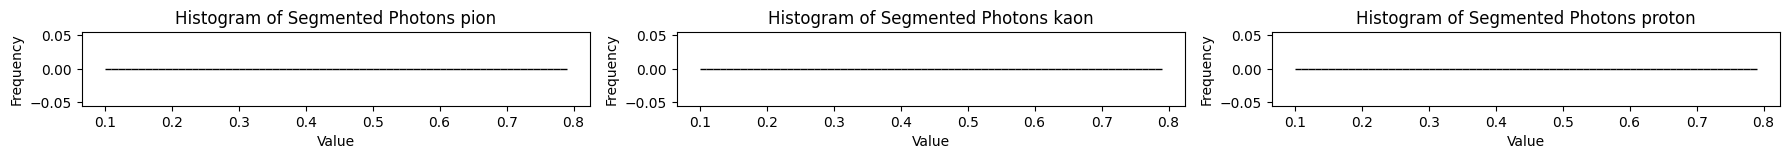

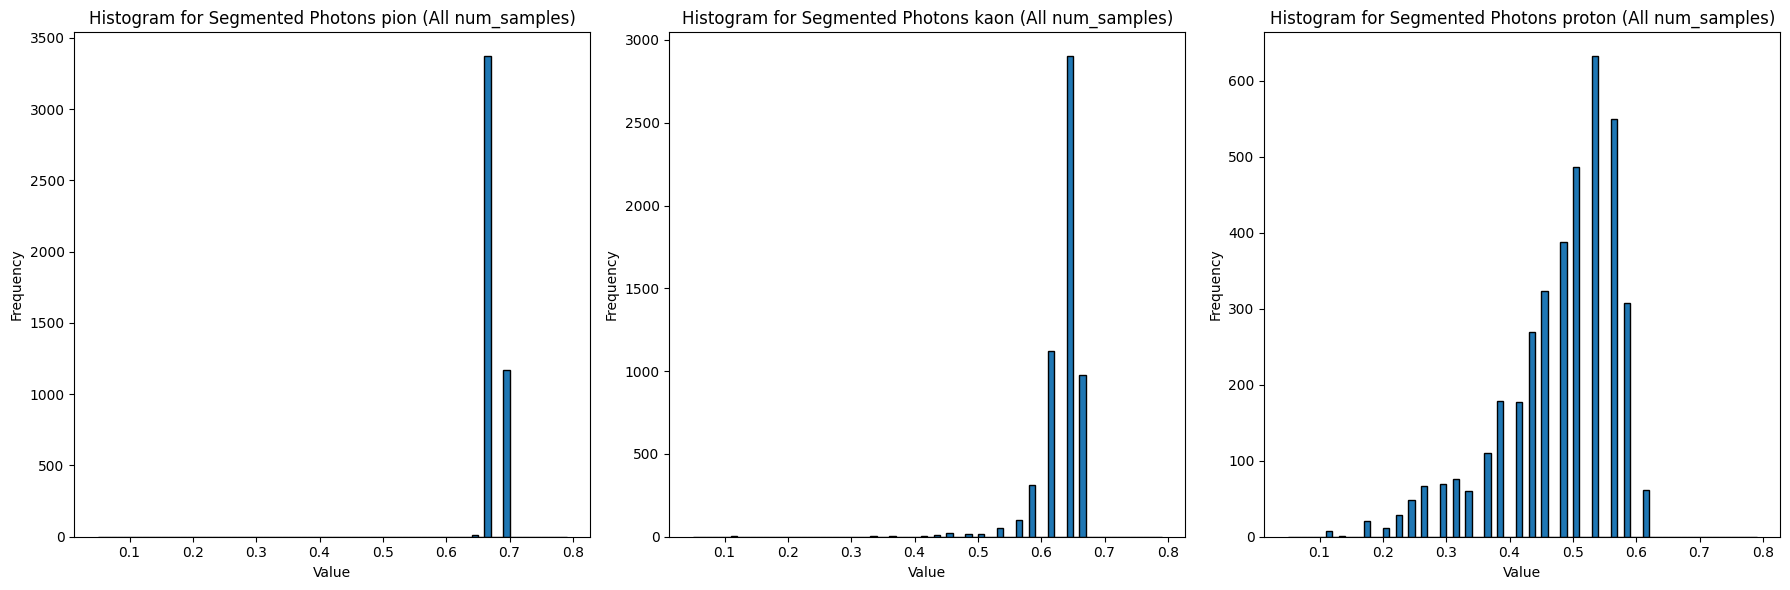

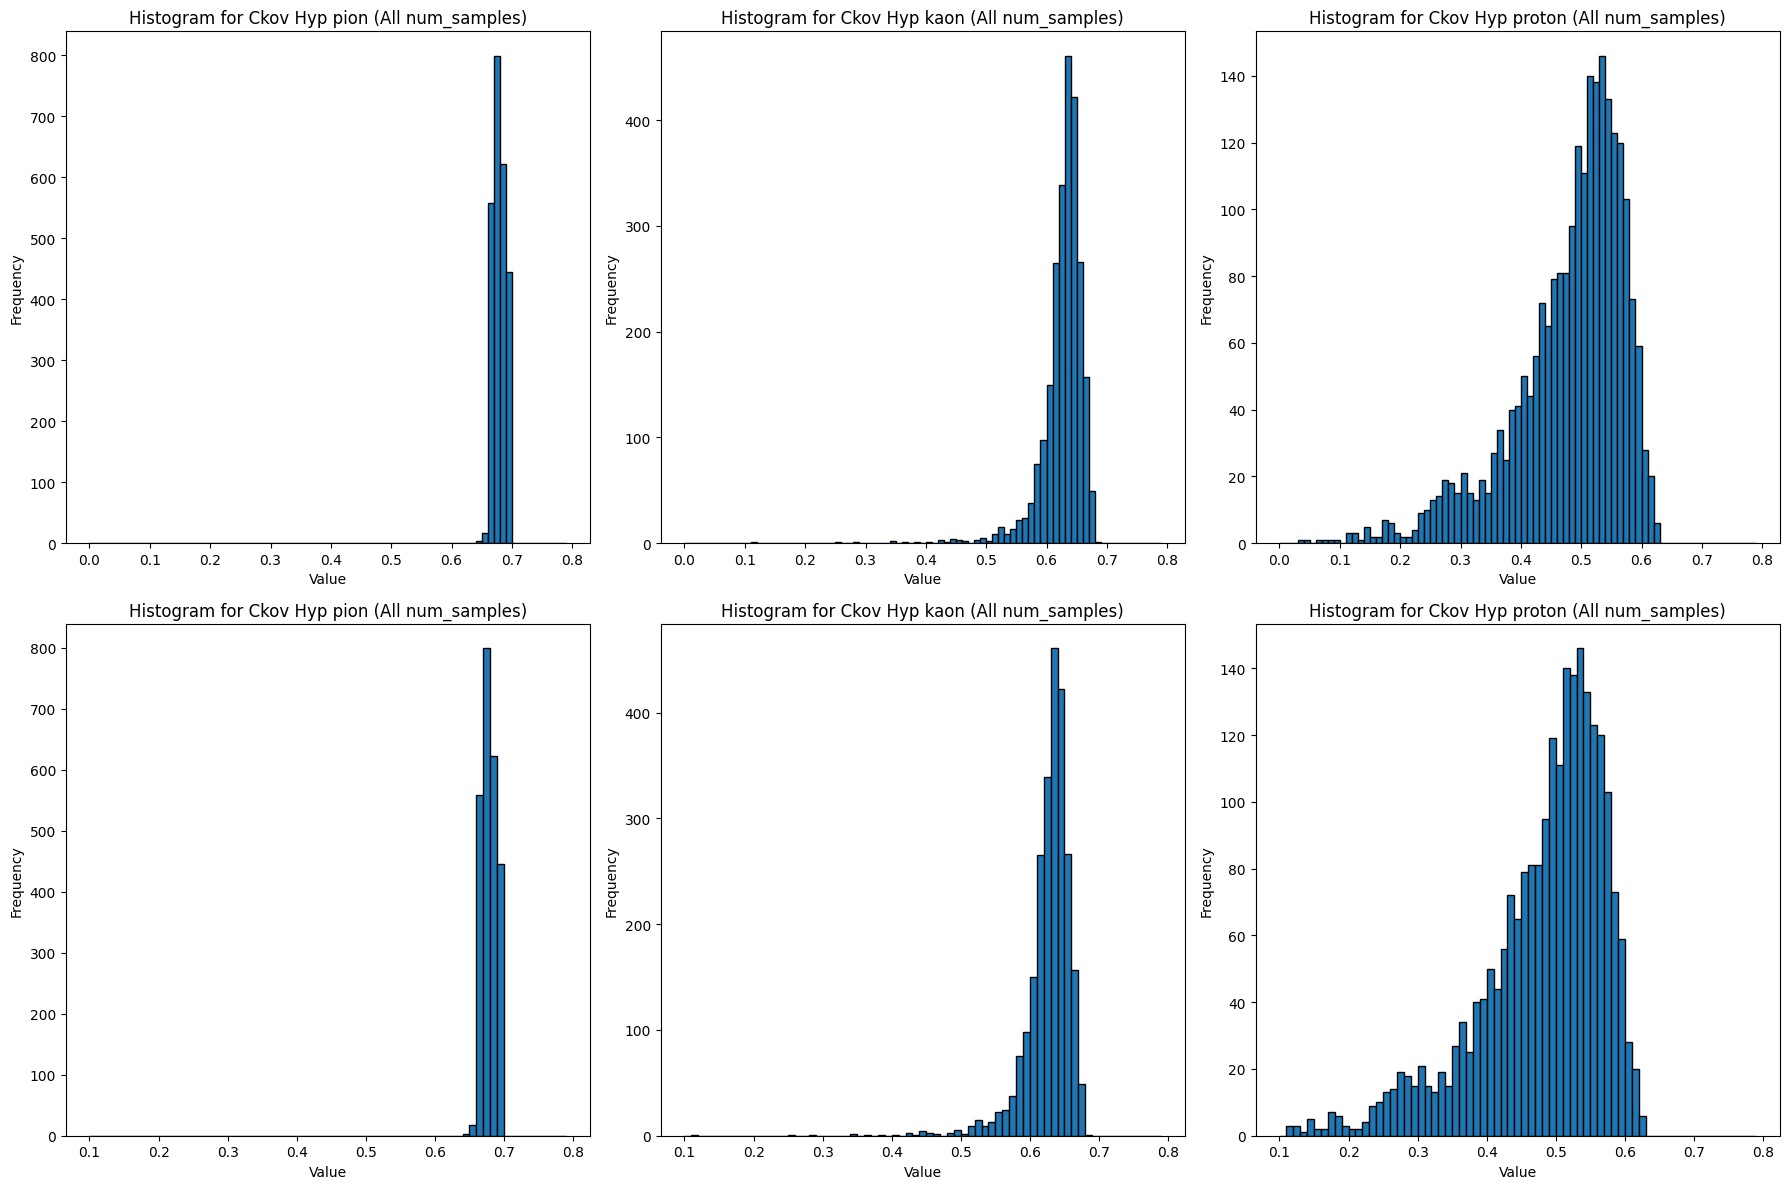

Counts of nan values for each array:  [0 0 0]
Counts of zero values for each array:  [176307 175296 176980]
X_train_mip_position shape = (1955, 2)
X_test_mip_position shape = (489, 2)


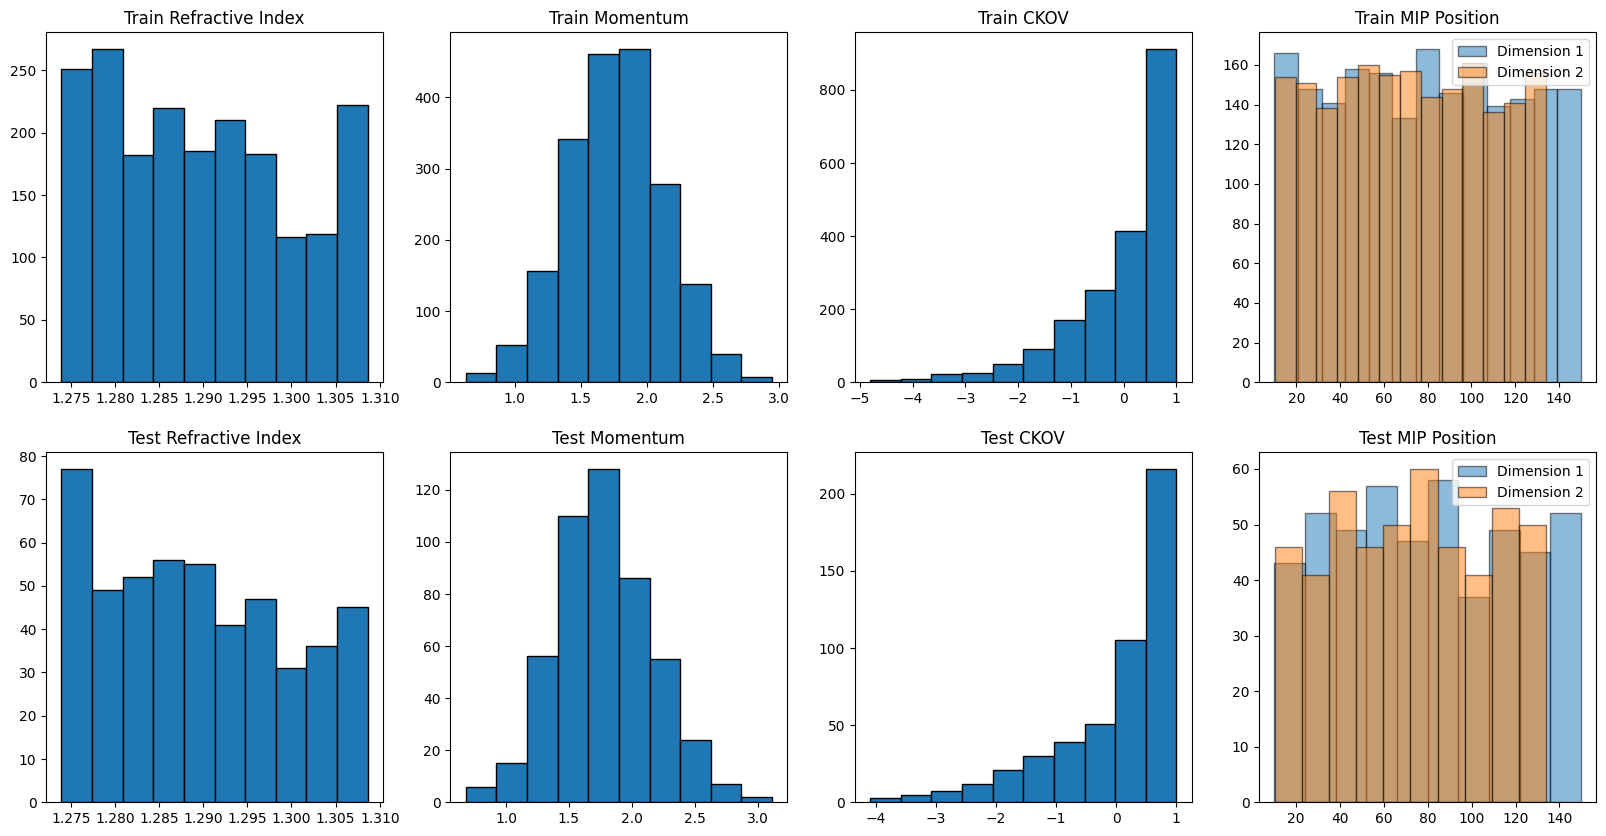

proton_candidates_train shape = (1955, 74)
X_train_photon_ckov_segmented shape = (1955, 3, 74)
 pion_candidates_test lastdim = 74
 kaon_candidates_train lastdim = 74
 proton_candidates_train lastdim = 74
pion_candidates_test Maximum value: 0.6975882129428775
pion_candidates_test Minimum value: 0.0
 pion_candidates_test lastdim = 74
 kaon_candidates_test lastdim = 74
 proton_candidates_test lastdim = 74
x_train shape = (3, 1955, 74)
pion_candidates_test shape = (489, 74)
proton_candidates_train_tf shape = (1955, 74)


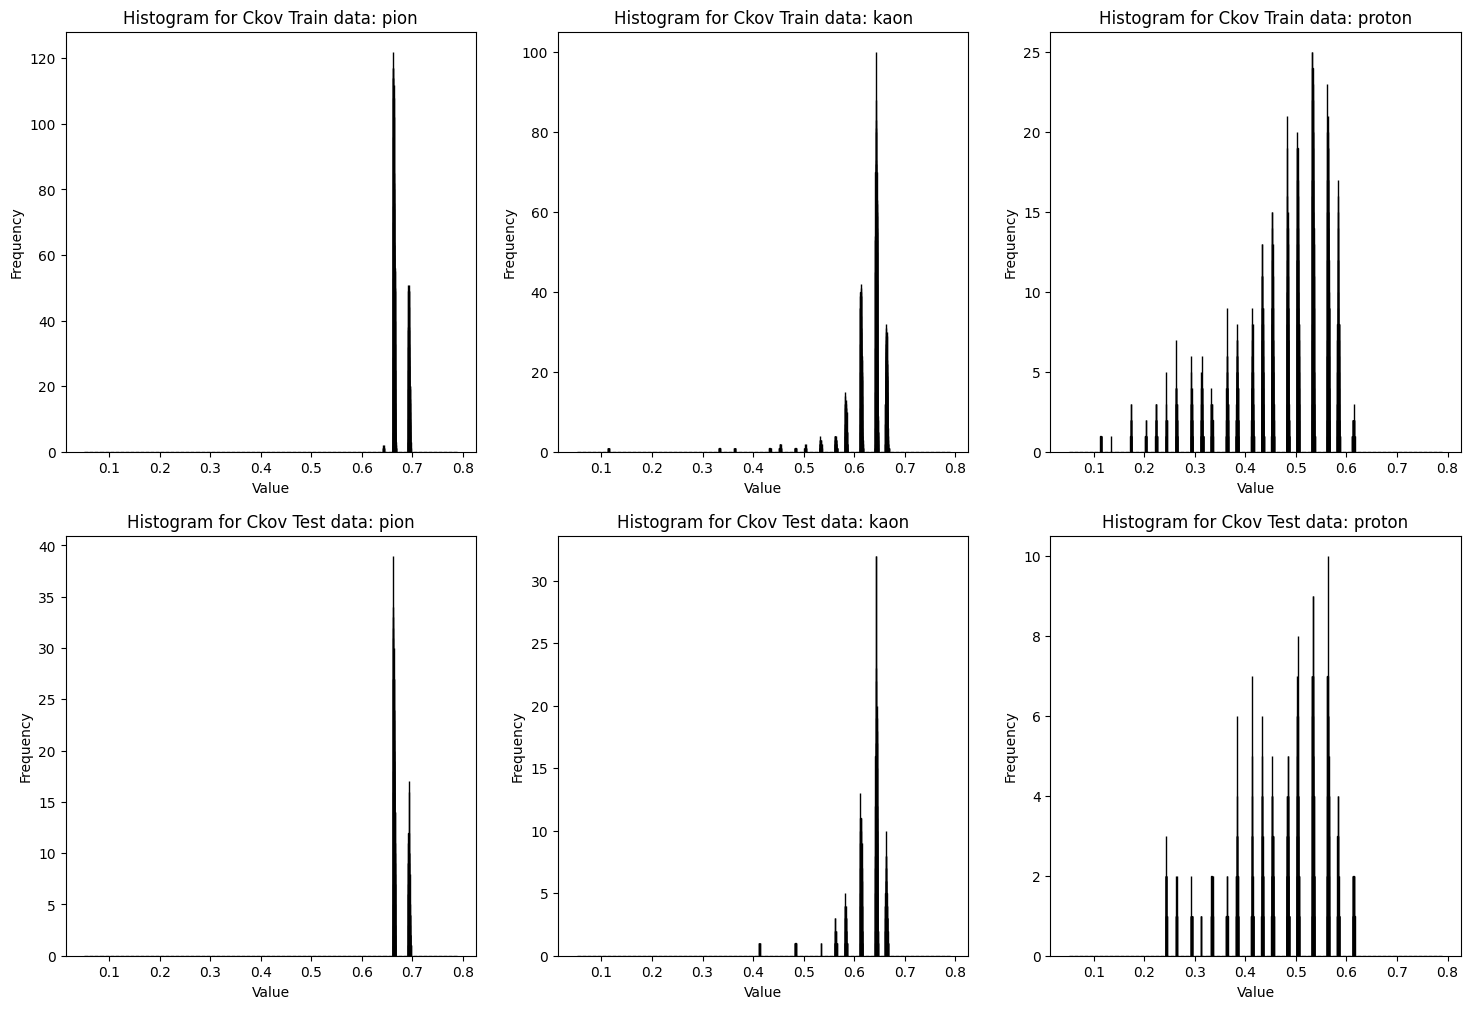

x_train_tf shape = (3, 1955, 74)


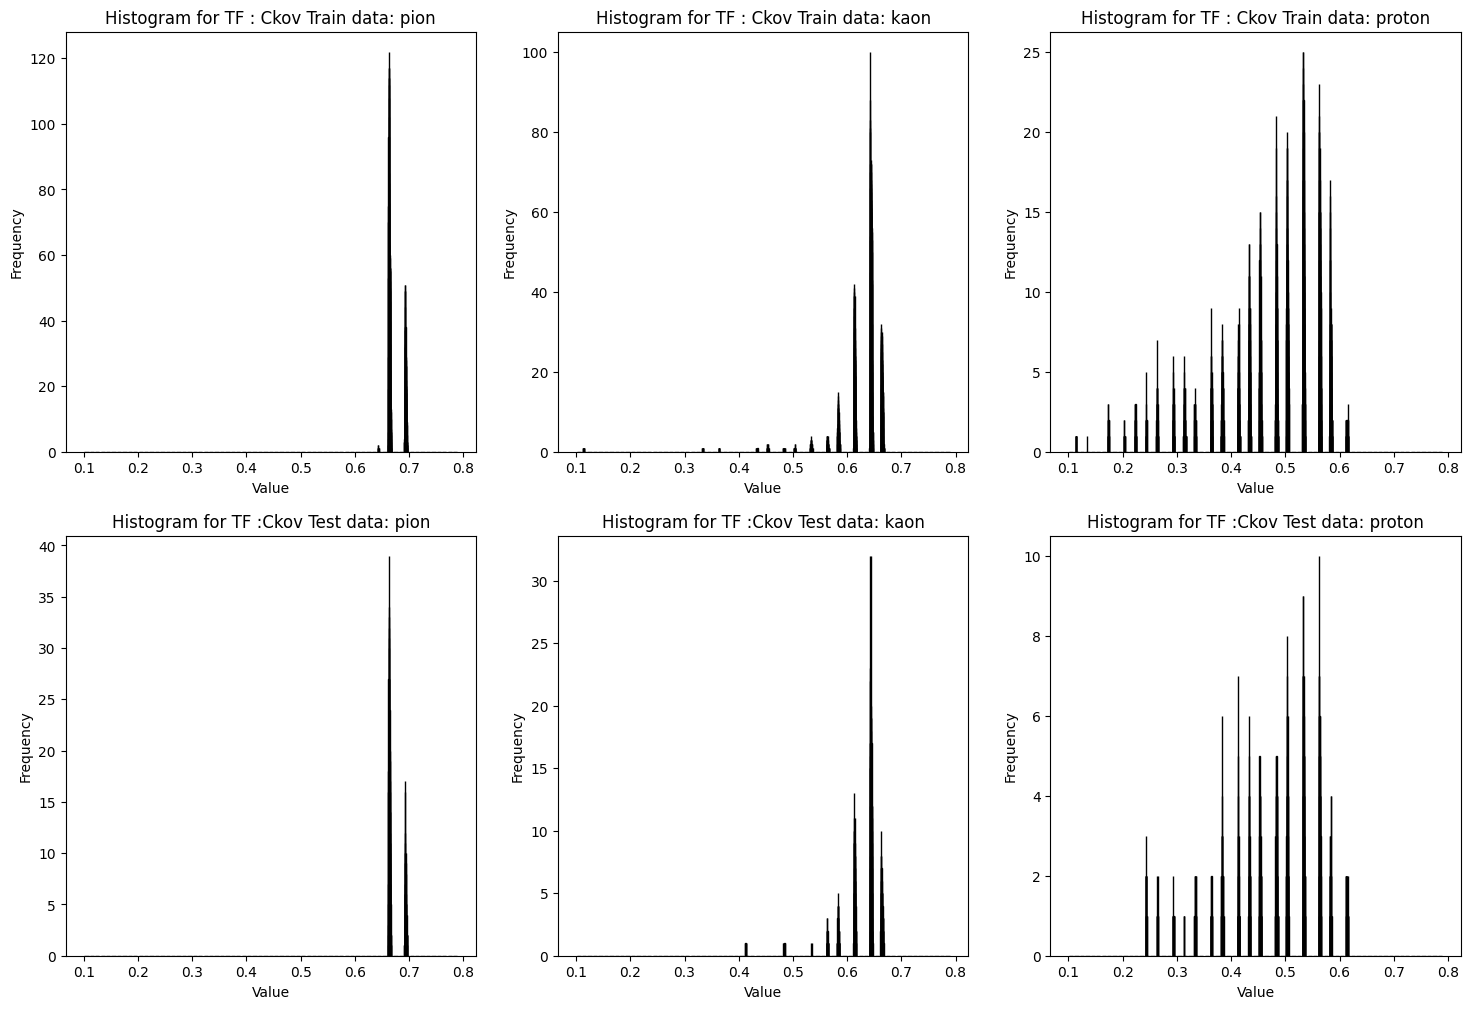

l1l2_weights_mip shape (1, 10, 3)
pion_candidates_test shape = (489, 74)
pion_candidates_test  = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pion_ip (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 kaon_ip (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 proton_ip (InputLayer)         [(None, 74)]         0           []                               
                                       

In [ ]:
#resolution = 4

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

import sys

print(sys.getrecursionlimit()) # Prints 1000

print_vals = False
from numpy.linalg import norm
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_curve, confusion_matrix

from scipy.signal import find_peaks

from __future__ import print_function
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, Lambda, Flatten, Dense, concatenate, BatchNormalization, MaxPooling2D, Dropout, LeakyReLU, Masking
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

class Constants:
    PION_MASS = 0.1396
    KAON_MASS = 0.4937
    PROTON_MASS = 0.938

np.set_printoptions(precision=4)

@staticmethod
def calculate_mass(momentum, refractiveIndex, ckov):
    """ args : momentum, refractiveIndex, ckov
        returns : mass
    """
    mass = momentum * np.sqrt((refractiveIndex * np.cos(ckov))**2 - 1)
    return mass


class ParticleDataUtils:
  
    class ParticleInfo:
        def __init__(self, momentum, mass, refractiveIndex, ckov, filledBins, mip_position, radiuses):

            self.momentum = momentum
            self.mass = mass
            self.refractiveIndex = refractiveIndex
            self.ckov = ckov
            self.filledBins = filledBins
            self.mip_position = mip_position
            self.mass_category = self.infer_mass_category_from_ckov(momentum, refractiveIndex, ckov)  # Infer mass category based on mass
            self.distances_to_mip = self.calculate_distances_to_mip()  # Calculate distances
            self.radiuses = radiuses

        @staticmethod
        def infer_mass_category_from_ckov(momentum, refractiveIndex, ckov):
            mass = momentum * np.sqrt((refractiveIndex * np.cos(ckov))**2 - 1)
            
            mass_category = "unknown"
            if abs(mass - Constants.PION_MASS) < 1e-4:
                mass_category = "pion"
            elif abs(mass - Constants.KAON_MASS) < 1e-4:
                mass_category = "kaon"
            elif abs(mass - Constants.PROTON_MASS) < 1e-4:
                mass_category = "proton"
            if print_vals:
              print(f"\ninfer_mass_category_from_ckov :  momentum = {momentum}|  mass_calc = {mass} |  mass_category={mass_category} | refractiveIndex = {refractiveIndex} | ckov = {ckov}")
            return mass_category

        @staticmethod
        def infer_mass_category(mass):
            if abs(mass - Constants.PION_MASS) < 1e-6:
                return "pion"
            elif abs(mass - Constants.KAON_MASS) < 1e-6:
                return "kaon"
            elif abs(mass - Constants.PROTON_MASS) < 1e-6:
                return "proton"
            else:
                return "unknown"

        def __str__(self):
            if print_vals:
              return (f"ParticleInfo(momentum={self.momentum} | mass={self.mass} |  mass_category={self.mass_category} | "
                      f"refractiveIndex={self.refractiveIndex} | ckov={self.ckov} | num_filled_bins={len(self.filledBins)}, "
                      f"mip_position={self.mip_position})")

        def calculate_distances_to_mip(self):
            """Calculate Euclidean distances from all filled bins to MIP position"""
            filledBins_np = np.array(self.filledBins)
            mip_position_np = np.array(self.mip_position)

            distances = np.linalg.norm(filledBins_np - mip_position_np, axis=1)
            return distances


    def __init__(self, filename = "default_filename.h5", percentage_to_read = 100):
        self.filename = filename
        self.percentage_to_read = percentage_to_read
        self.particle_vector = self.load_data(filename)
        self.particle_info = self.process_data(self.particle_vector, self.percentage_to_read)
        self.num_particles = len(self.particle_info)
        self.momentum_scaler, self.momentum_stats = self.create_scaler("momentum")
        self.refractive_index_scaler, self.refractive_index_stats = self.create_scaler("refractiveIndex")
        self.ckov_scaler, self.ckov_stats = self.create_scaler("ckov")
        self.distances_scaler, self.distances_stats = self.create_scaler("distances")


    def load_data(self, filename):
        drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'  # Update the path to your Google Drive folder
        file_path = os.path.join(drive_path, filename)
        particle_vector = []

        print(f"load_data : reading file {filename}")
        print(f"load_data : location {drive_path}")

        with h5py.File(file_path, 'r') as file:
            #file.visititems(print_hdf5_items)
            for i, group_name in enumerate(file):
                group = file[group_name]

                # Read scalar values
                momentum = group.attrs['Momentum']
                mass = group.attrs['Mass']
                refractive_index = group.attrs['RefractiveIndex']
                ckov = group.attrs['Ckov']
                mip_position = group['MipPos']
                mip_position = mip_position[...]  # Retrieve the data as a numpy array

                mip_position = mip_position.tolist()  # Convert the numpy array to a list

                # Read filledBins
                filled_bins_dataset = group['FilledBins']
                filled_bins_data = filled_bins_dataset[...]  # Retrieve the data as a numpy array

                filled_bins = filled_bins_data.tolist()  # Convert the numpy array to a list

                # get window : 
                calculator = CkovCalculator()
                results = calculator.calcCkovFromMass(momentum, refractive_index)
                radiuses = []
                for particle, radius in results.items():
                    #print(f"{particle} Radius: {radius}")
                    radiuses.append(radius)

                # the biggest radius should then extract a window around the MIP 

                # Find the particle with the biggest radius
                #max_radius_particle = max(radiuses, key=radiuses.get)
                #max_radius = radiuses[max_radius_particle]
                max_radius = radiuses[2]

                # Extract a window around the MIP using the biggest radius
                #window_size = int(max_radius * 2)  # Adjust the size as needed      
                # NB!!! add resolution here? Or multiply elswhere..

                particle_info = ParticleDataUtils.ParticleInfo(
                    momentum, mass, refractive_index, ckov, filledBins=filled_bins, mip_position=mip_position, radiuses = radiuses)
                if print_vals == True:
                  print(particle_info)  # This will use the __str__() method of ParticleInfo

                particle_vector.append(particle_info)

        return particle_vector

    def process_data(self, particle_vector, percentage):

        # Calculate the number of particles based on the percentage
        num_particles = int(len(particle_vector) * (percentage / 100.0))

        # Slice the particle_vector to the desired percentage
        particle_vector = particle_vector[:num_particles]
        return particle_vector


    def create_scaler(self, feature):
        if feature == "momentum":
            values = np.array([info.momentum for info in self.particle_info]).reshape(-1, 1)
        elif feature == "refractiveIndex":
            values = np.array([info.refractiveIndex for info in self.particle_info]).reshape(-1, 1)
        elif feature == "ckov":
            values = np.array([info.ckov for info in self.particle_info]).reshape(-1, 1)
        elif feature == "distances":
            distances = []
            for info in self.particle_info:
                distances.extend(info.distances_to_mip)
            values = np.array(distances).reshape(-1, 1)
        else:
            raise ValueError(f"Invalid feature: {feature}")

        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(values)
        stats = {
            "mean": scaler.mean_[0],
            "std": scaler.scale_[0]
        }
        return scaler, stats



# create a map, the resolution is the "inverse" 
def create_map(filledBins=None, resolution=4):
    map_shape = (int(144 * resolution), int(160 * resolution))
    map_data = np.zeros(map_shape, dtype=np.int32)
   
    if filledBins is not None:
        filledBins_np = np.array(filledBins)
        indices = (filledBins_np * resolution).astype(int)
        map_data[indices[:, 1], indices[:, 0]] = 1

    return map_data

class MassClassifier:
    def __init__(self, percentage_to_read = 10, resolution = 4):
        self.model = None
        self.utils = None
        self.percentage_to_read = percentage_to_read
        self.resolution = resolution


    def load_data(self, filename):
        self.utils = ParticleDataUtils(filename, percentage_to_read = self.percentage_to_read) # specify percentage of particles to read..
        print(f"Number of particles: {self.utils.num_particles}")

    def preprocess_data(self):
        particle_info = self.utils.particle_info


        # Prepare the inputs
        
        # create a map with resolution to be chosen, iterate over teh filledBins vector
        X_map = np.array([create_map(filledBins = info.filledBins, resolution = self.resolution) for info in particle_info])
        filled_bins_array = np.array([info.filledBins for info in particle_info], dtype=object)



        X_momentum = np.array([info.momentum for info in particle_info])#.reshape(-1, 32, 32, 1)
        X_refractive_index = np.array([info.refractiveIndex for info in particle_info])#.reshape(-1, 32, 32, 1)
        X_ckov = np.array([info.ckov for info in particle_info])#.reshape(-1, 32, 32, 1)
        X_mip_position = np.array([info.mip_position for info in particle_info])




        # calculate radiuses (radius of f(m_i) where m_i = [m_pion, m_kaon, m_proton],  and n, p, + later {xRad, yRad, theta, phi} fixed for a given track) 
        # for mass-hypothesis

        #alc_dist2mip(maps = None,  mip_positions = None, resolution = 10):
        
        try:
          plot_maps(filled_bins_array=filled_bins_array, map_array=X_map, mip_position_array=X_mip_position, X_momentum=X_momentum, X_refractive_index=X_refractive_index, X_ckov=X_ckov, percentage_to_plot=5, resolution = self.resolution)
        except Exception as e:
          print(f"plot_maps failed due to error : {e}")
        
        # change shape to be num_samples, pad_sequences, 3:



        X_dist2mip = calc_dist2mip(maps = X_map, mip_positions = X_mip_position, resolution = self.resolution)

        #
        calculator2 = CkovCalculator()


        # Segment the regions : 

        # num_samplesx3 array holding the ckovangles from teh masshypotheses:
        X_momentum = np.asarray(X_momentum)
        X_refractive_index = np.asarray(X_refractive_index)
        ckov_hyp = calc_ckov_hyp(p = X_momentum, n = X_refractive_index)


        #cherenkov_photon_candidates = np.concatenate(cherenkov_photon_candidates)
        #ckov_hyp = np.concatenate(ckov_hyp)


        # createa a num_samplesx3x<var_length> vector
        X_dist2mip = pad_sequences(X_dist2mip, padding='post')

        X_photon_ckov = calculator2.get_ckov_from_radius(radius = X_dist2mip, resolution = self.resolution)

        # Create a num_samplesx3x<var_length> vector holding for each num_samples the segmented photon-angles, in each of the regions 
        # theta_ckov in {ckov_pion +- std.dev, ckov_kaon +- std.dev, ckov_proton +- std.dev}
        X_photon_ckov_segmented = segment_photons(X_photon_ckov, ckov_hyp)
        #X_photon_ckov_segmented = pad_sequences(X_photon_ckov_segmented, padding='post')


        # Normalize the inputs NB commented out scaling !!!
        #X_momentum = self.utils.momentum_scaler.transform(X_momentum.reshape(-1, 1))#.reshape(-1, 32, 32, 1)
        #X_refractive_index = self.utils.refractive_index_scaler.transform(X_refractive_index.reshape(-1, 1))#.reshape(-1, 32, 32, 1)
        X_ckov = self.utils.ckov_scaler.transform(X_ckov.reshape(-1, 1))#.reshape(-1, 32, 32, 1)


        # NB, commented these out, leads to problem?
        #X_mip_position[0,:] = self.utils.distances_scaler.transform(X_mip_position[0,:])
        #X_mip_position[1,:] = self.utils.distances_scaler.transform(X_mip_position[1,:])



        # Prepare the outputs
        y = np.array([info.mass_category for info in particle_info])

        # Convert the outputs to one-hot encoded vectors
        lb = LabelBinarizer()
        y = lb.fit_transform(y)

        # Split the data into train and test sets

        X_train_dist2mip, X_test_dist2mip, X_train_map, X_test_map, X_train_momentum, X_test_momentum, X_train_refractive_index, X_test_refractive_index, \
            X_train_ckov, X_test_ckov, X_train_mip_position, X_test_mip_position, y_train, y_test = \
            train_test_split(X_dist2mip, X_map, X_momentum, X_refractive_index, X_ckov, X_mip_position, y, test_size=0.2, random_state=42)

        # Suppose X_photon_ckov_segmented is your data
        X_train_photon_ckov_segmented, X_test_photon_ckov_segmented = \
            train_test_split(X_photon_ckov_segmented, test_size=0.2, random_state=42)

        X_train = {"X_train_map": X_train_map, 
                  "X_train_momentum": X_train_momentum, 
                  "X_train_refractive_index": X_train_refractive_index,
                  "X_train_ckov": X_train_ckov, 
                  "X_train_mip_position": X_train_mip_position, 
                  "X_train_dist2mip": X_train_dist2mip, 
                  "X_train_photon_ckov_segmented": X_train_photon_ckov_segmented}

        X_test = {"X_test_map": X_test_map, 
                  "X_test_momentum": X_test_momentum, 
                  "X_test_refractive_index": X_test_refractive_index,
                  "X_test_ckov": X_test_ckov, 
                  "X_test_mip_position": X_test_mip_position, 
                  "X_test_dist2mip": X_test_dist2mip,
                  "X_test_photon_ckov_segmented": X_test_photon_ckov_segmented}

        return (X_train, X_test, y_train, y_test)

    def build_model(self, input_sequence_length = None):

        #map_shape = (None, None, 1)  # Variable shape for the map input
        X_train, X_test, y_train, y_test = self.preprocess_data()
        #X_train_photon_ckov_segmented shape : (1955, 3, 74) 
        

        X_train_refractive_index =  X_train["X_train_refractive_index"]
        X_train_momentum = X_train["X_train_momentum"]
        X_train_mip_position = X_train["X_train_mip_position"]
        X_train_ckov = X_train["X_train_ckov"]


        X_test_refractive_index = X_test["X_test_refractive_index"]
        X_test_momentum = X_test["X_test_momentum"]
        X_test_mip_position = X_test["X_test_mip_position"]
        X_test_ckov = X_test["X_test_ckov"]

        fig, axs = plt.subplots(2, 4, figsize=(20, 10))  

        # For train data
        train_variables = [X_train_refractive_index, X_train_momentum, X_train_ckov, X_train_mip_position]
        train_labels = ['Train Refractive Index', 'Train Momentum', 'Train CKOV', 'Train MIP Position']

        X_train_mip_position = (np.asarray(X_train_mip_position)).reshape(len(X_train_mip_position), 2)
        print(f"X_train_mip_position shape = {X_train_mip_position.shape}")
        for i, variable in enumerate(train_variables):
            if i < 3:#variable.ndim == 1: # For 1D data
                axs[0, i].hist(variable, edgecolor='black')
                axs[0, i].set_title(train_labels[i])
            else: # For 2D data
                axs[0, i].hist(X_train_mip_position[:, 0], alpha=0.5, bins = "auto", edgecolor='black', label='Dimension 1')
                axs[0, i].hist(X_train_mip_position[:, 1], alpha=0.5, bins = "auto", edgecolor='black', label='Dimension 2')
                axs[0, i].set_title(train_labels[i])
                axs[0, i].legend()

        # For test data
        test_variables = [X_test_refractive_index, X_test_momentum, X_test_ckov, X_test_mip_position]
        test_labels = ['Test Refractive Index', 'Test Momentum', 'Test CKOV', 'Test MIP Position']


        X_test_mip_position = (np.asarray(X_test_mip_position)).reshape(len(X_test_mip_position), 2)
        print(f"X_test_mip_position shape = {X_test_mip_position.shape}")

        for i, variable in enumerate(test_variables):
            if i < 3:#variable.ndim == 1: # For 1D data
                axs[1, i].hist(variable, edgecolor='black')
                axs[1, i].set_title(test_labels[i])
            else: # For 2D data
                axs[1, i].hist(X_test_mip_position[:, 0], alpha=0.5, edgecolor='black', bins = "auto", label='Dimension 1')
                axs[1, i].hist(X_test_mip_position[:, 1], alpha=0.5, edgecolor='black', bins = "auto", label='Dimension 2')
                axs[1, i].set_title(test_labels[i])
                axs[1, i].legend()

        plt.show()

        X_train_photon_ckov_segmented = np.asarray(X_train["X_train_photon_ckov_segmented"], dtype = object)
        X_test_photon_ckov_segmented = np.asarray(X_test["X_test_photon_ckov_segmented"], dtype = object)

        pion_candidates_train = X_train_photon_ckov_segmented[:,0,:]
        kaon_candidates_train = X_train_photon_ckov_segmented[:,1,:]
        proton_candidates_train = X_train_photon_ckov_segmented[:,2,:]

        print(f"proton_candidates_train shape = {proton_candidates_train.shape}")
        print(f"X_train_photon_ckov_segmented shape = {X_train_photon_ckov_segmented.shape}")

        
        pion_candidates_test = X_test_photon_ckov_segmented[:,0,:]
        kaon_candidates_test = X_test_photon_ckov_segmented[:,1,:]
        proton_candidates_test = X_test_photon_ckov_segmented[:,2,:]
        

        len_pion = np.asarray(pion_candidates_test, dtype = object).shape[1]
        len_kaon = np.asarray(kaon_candidates_train, dtype = object).shape[1]
        len_proton = np.asarray(proton_candidates_train, dtype = object).shape[1]

        print(f" pion_candidates_test lastdim = {len_pion}")
        print(f" kaon_candidates_train lastdim = {len_kaon}")
        print(f" proton_candidates_train lastdim = {len_proton}")

        max_value = np.max(pion_candidates_test)

        # Find the minimum value across all dimensions
        min_value = np.min(pion_candidates_test)

        print("pion_candidates_test Maximum value:", max_value)
        print("pion_candidates_test Minimum value:", min_value)

        print(f" pion_candidates_test lastdim = {np.asarray(pion_candidates_test, dtype = object).shape[1]}")
        print(f" kaon_candidates_test lastdim = {np.asarray(kaon_candidates_test, dtype = object).shape[1]}")
        print(f" proton_candidates_test lastdim = {np.asarray(proton_candidates_test, dtype = object).shape[1]}")
        


        pion_candidates_test = X_test_photon_ckov_segmented[:,0,:]
        kaon_candidates_test = X_test_photon_ckov_segmented[:,1,:]
        proton_candidates_test = X_test_photon_ckov_segmented[:,2,:] 
        
        pion_candidates_train = np.array(pion_candidates_train).astype(np.float32)
        kaon_candidates_train = np.array(kaon_candidates_train).astype(np.float32)
        proton_candidates_train = np.array(proton_candidates_train).astype(np.float32)

        # Convert the test candidates to tensors
        pion_candidates_test = np.array(pion_candidates_test).astype(np.float32)
        kaon_candidates_test = np.array(kaon_candidates_test).astype(np.float32)
        proton_candidates_test = np.array(proton_candidates_test).astype(np.float32)

        x_train = np.asarray([pion_candidates_train, kaon_candidates_train, proton_candidates_train], dtype = "object")
        x_test = np.asarray([pion_candidates_test, kaon_candidates_test, proton_candidates_test], dtype = "object")


        # Convert to TensorFlow tensors
        pion_candidates_train_tf = tf.convert_to_tensor(pion_candidates_train)
        kaon_candidates_train_tf = tf.convert_to_tensor(kaon_candidates_train)
        proton_candidates_train_tf = tf.convert_to_tensor(proton_candidates_train)


        # Convert to TensorFlow tensors
        pion_candidates_test_tf = tf.convert_to_tensor(pion_candidates_test)
        kaon_candidates_test_tf = tf.convert_to_tensor(kaon_candidates_test)
        proton_candidates_test_tf = tf.convert_to_tensor(proton_candidates_test)


        #x_train shape = (3, 1955, 74) pion_candidates_test shape = (489, 74) proton_candidates_train_tf shape = (1955, 74)
        print(f"x_train shape = {np.asarray(x_train, dtype = object).shape}")
        print(f"pion_candidates_test shape = {np.asarray(pion_candidates_test, dtype = object).shape}")
        print(f"proton_candidates_train_tf shape = {np.asarray(proton_candidates_train_tf, dtype = object).shape}")



        fig2, axs2 = plt.subplots(2, 3, figsize=(18, 12))
        strings_desc = ["pion", "kaon", "proton"]
        for i in range(3):
            axs2[0, i].hist(x_train[i, :, :],  bins=np.arange(0.05, 0.8, 0.01), edgecolor='black')
            axs2[0, i].set_title(f'Histogram for Ckov Train data: {strings_desc[i]}')
            axs2[0, i].set_xlabel('Value')
            axs2[0, i].set_ylabel('Frequency')

            axs2[1, i].hist(x_test[i, :, :],  bins=np.arange(0.05, 0.8, 0.01), edgecolor='black')
            axs2[1, i].set_title(f'Histogram for Ckov Test data: {strings_desc[i]}')
            axs2[1, i].set_xlabel('Value')
            axs2[1, i].set_ylabel('Frequency')

        plt.show()

        x_train_tf = np.asarray([pion_candidates_train, kaon_candidates_train, proton_candidates_train], dtype = object)
        x_test_tf = np.asarray([pion_candidates_test, kaon_candidates_test, proton_candidates_test], dtype = object)


        print(f"x_train_tf shape = {x_train_tf.shape}")

        fig3, axs3 = plt.subplots(2, 3, figsize=(18, 12))
        for i in range(3):
            axs3[0, i].hist(x_train_tf[i, :, :],  bins=np.arange(0.1, 0.8, 0.01), edgecolor='black')
            axs3[0, i].set_title(f'Histogram for TF : Ckov Train data: {strings_desc[i]}')
            axs3[0, i].set_xlabel('Value')
            axs3[0, i].set_ylabel('Frequency')

            axs3[1, i].hist(x_test_tf[i, :, :],  bins=np.arange(0.1, 0.8, 0.01), edgecolor='black')
            axs3[1, i].set_title(f'Histogram for TF :Ckov Test data: {strings_desc[i]}')
            axs3[1, i].set_xlabel('Value')
            axs3[1, i].set_ylabel('Frequency')

        plt.show()


        momentum_shape = (1,)
        refractive_index_shape = (1,)
        mip_position_shape = (2,)

        # Grid search parameters
        # Grid search parameters
        filter_sizes = [5]  # Filter sizes to test
        num_filters = [32]#[16, 32]  # Number of filters to test
        strides = [(2, 2)]#[(1, 1), (2, 2)]  # Strides to test
        pool_sizes = [(2, 2)]  # Max pooling sizes to test
        fc1_units = [64]#, 128]  # Number of units in fc1 to test
        fc2_units = [32]#, 32]  # Number of units in fc2 to test

        dropouts = [0.2, 0.3, 0.4]
        best_accuracy = 0
        best_model = None
        alphas = [0.005, 0.05, 0.1]
        
        l1l2_weights_mip = [
            [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
            (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
        ]
        l1l2_weights_mip = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_mip]

        l1l2_weights_ref_index = [
            [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
            (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
        ]
        l1l2_weights_ref_index = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_ref_index]

        l1l2_weights_hadrons = [
            [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
            (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),
            (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1)]
        ]
        l1l2_weights_hadrons = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_hadrons]

        l1l2_weights_momentum = [
            [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
            (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
        ]
        l1l2_weights_momentum = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_momentum]


        l1l2_weights_mip = [[(0.0001, 0.0001, 0.0001) for _ in sublist] for sublist in l1l2_weights_mip]

        l1l2_weights_ref_index = [[(0.0001, 0.0001, 0.0001) for _ in sublist] for sublist in l1l2_weights_ref_index]

        l1l2_weights_hadrons = [[(0.0001, 0.0001, 0.0001) for _ in sublist] for sublist in l1l2_weights_hadrons]

        l1l2_weights_momentum = [[(0.0001, 0.0001, 0.0001) for _ in sublist] for sublist in l1l2_weights_momentum]


        print(f"l1l2_weights_mip shape {np.array(l1l2_weights_mip, dtype =object).shape}")

        for dropout in dropouts:
            for num_filter in num_filters:
                for stride in strides:
                    for alpha in alphas:
                        for fc1_unit in fc1_units:
                            for fc2_unit in fc2_units:

                                pion_ip = Input(shape=(len_pion, ), name="pion_ip")
                                kaon_ip = Input(shape=(len_kaon, ), name="kaon_ip")
                                proton_ip = Input(shape=(len_proton, ), name="proton_ip")

                                momentum_input = Input(shape=momentum_shape, name="momentum_input")
                                refractive_index_input = Input(shape=refractive_index_shape, name="refractive_index_input")
                                mip_position_input = Input(shape=mip_position_shape, name="mip_position_input")

                                print(f"pion_candidates_test shape = {pion_candidates_test.shape}")
                                print(f"pion_candidates_test  = {pion_candidates_test}")

                                # check for nan
                                #nan_count = np.isnan(pion_candidates_test).sum()

                                # print the number of nan
                                #print(f"Number of nan values in pion_candidates_test = {nan_count}")
                                pion_ip_mask = Masking(mask_value=0.)(pion_ip)
                                kaon_ip_mask = Masking(mask_value=0.)(kaon_ip)
                                proton_ip_mask = Masking(mask_value=0.)(proton_ip)

                                #prev_dist2mip_layer = dist2mip_masked

                                units = [fc1_unit * i for i in [1, 2, 4, 8, 16, 32, 64, 128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25]]
                                units = [fc1_unit * i for i in [1, 2, 4, 8, 16, 32, 16, 8, 4, 2, 1, 0.5, 0.25]]


                                prev_pion = pion_ip_mask
                                prev_kaon = kaon_ip_mask
                                prev_proton = proton_ip_mask



                                for i in range(1, len(units)):
                                    unit = int(units[i])
                                    
                                    # For pion
                                    dense_pion_i = Dense(unit, name=f"dense_pion_{i}",
                                                        kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                                        bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_pion)

                                    bn_pion_i = BatchNormalization(name=f"bn_pion_{i}")(dense_pion_i)
                                    leakyrelu_pion_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_pion_{i}")(bn_pion_i)
                                    dropout_pion_i = Dropout(dropout, name=f"dropout_pion_{i}")(leakyrelu_pion_i)
                                    prev_pion = dropout_pion_i

                                    # For kaon
                                    dense_kaon_i = Dense(unit, name=f"dense_kaon_{i}",
                                                        kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                                        bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_kaon)

                                    bn_kaon_i = BatchNormalization(name=f"bn_kaon_{i}")(dense_kaon_i)
                                    leakyrelu_kaon_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_kaon_{i}")(bn_kaon_i)
                                    dropout_kaon_i = Dropout(dropout, name=f"dropout_kaon_{i}")(leakyrelu_kaon_i)
                                    prev_kaon = dropout_kaon_i

                                    # For proton
                                    dense_proton_i = Dense(unit, name=f"dense_proton_{i}",
                                                          kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                                          bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_proton)

                                    bn_proton_i = BatchNormalization(name=f"bn_proton_{i}")(dense_proton_i)
                                    leakyrelu_proton_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_proton_{i}")(bn_proton_i)
                                    dropout_proton_i = Dropout(dropout, name=f"dropout_proton_{i}")(leakyrelu_proton_i)
                                    prev_proton = dropout_proton_i


                                units2 = [fc1_unit * i for i in [1, 2, 4, 8, 16, 4, 2, 1, 0.5, 0.25]]
                                units2 = [fc1_unit * i for i in [1, 2, 4, 8, 4, 2, 1, 0.5, 0.25]]

                                prev_mip = mip_position_input
                                prev_momentum = momentum_input
                                prev_ref_index = refractive_index_input

                                for i in range(1, len(units2)):
                                    step = int(units2[i])

                                    dense_ref_index_i = Dense(step, name=f"dense_ref_index_{i}",
                                                              kernel_regularizer=regularizers.L1L2(l1l2_weights_ref_index[0][i - 1][0], l1l2_weights_ref_index[0][i - 1][1]),
                                                              bias_regularizer=regularizers.L1(l1l2_weights_ref_index[0][i - 1][2]))(prev_ref_index)


                                    bn_ref_index_i = BatchNormalization(name=f"bn_ref_index_{i}")(dense_ref_index_i)
                                    leakyrelu_ref_index_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_ref_index_{i}")(bn_ref_index_i)
                                    dropout_ref_index_i = Dropout(dropout, name=f"dropout_ref_index_{i}")(leakyrelu_ref_index_i)

                                    dense_momentum_i = Dense(step, name=f"dense_momentum_{i}",
                                                            kernel_regularizer=regularizers.L1L2(l1l2_weights_momentum[0][i - 1][0], l1l2_weights_momentum[0][i - 1][1]),
                                                            bias_regularizer=regularizers.L1(l1l2_weights_momentum[0][i - 1][2]))(prev_momentum)
                                    bn_momentum_i = BatchNormalization(name=f"bn_momentum_{i}")(dense_momentum_i)
                                    leakyrelu_momentum_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_momentum_{i}")(bn_momentum_i)
                                    dropout_momentum_i = Dropout(dropout, name=f"dropout_momentum_{i}")(leakyrelu_momentum_i)

                                    dense_mip_pos_i = Dense(step, name=f"dense_mip_pos_{i}",
                                                            kernel_regularizer=regularizers.L1L2(l1l2_weights_mip[0][i - 1][0], l1l2_weights_mip[0][i - 1][1]),
                                                            bias_regularizer=regularizers.L1(l1l2_weights_mip[0][i - 1][2]))(prev_ref_index)

                                    bn_mip_pos_i = BatchNormalization(name=f"bn_mip_pos_{i}")(dense_mip_pos_i)
                                    leakyrelu_mip_pos_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_mip_pos_{i}")(bn_mip_pos_i)
                                    dropout_mip_pos_i = Dropout(dropout, name=f"dropout_mip_pos_{i}")(leakyrelu_mip_pos_i)

                                    prev_mip = dropout_mip_pos_i
                                    prev_momentum = dropout_momentum_i
                                    prev_ref_index = dropout_ref_index_i

                              
                                epochs = 100
                                lr = create_lr_scheduler(num_epochs=epochs)

                                concat = concatenate([prev_pion, prev_kaon, prev_proton, prev_ref_index, prev_momentum, prev_mip])

                                # dense_concat = Dense(16, name="dense_concat")(concat)
                                # bn_concat = BatchNormalization(name="bn_concat")(dense_concat)
                                # relu_concat = LeakyReLU(alpha=alpha, name=f"relu_concat")(bn_concat)
                                # dropout_concat = Dropout(dropout, name="dropout_concat")(relu_concat)



                                output = Dense(3, activation='softmax')(concat) # NB LEGG MERKE TIL AT DENNE ER ENDRET FRA FC2

                                model = Model(inputs=[pion_ip, kaon_ip, proton_ip, refractive_index_input, momentum_input, mip_position_input],
                                              outputs=output)

                                #model = Model(inputs=[window_input], outputs=[output])
                                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # NB changed from 0.0002
                                              loss="categorical_crossentropy", metrics=["accuracy"])
                                model.summary()
                                

                              
  

                                # Train the model
                                history = model.fit(
                                    x=[pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf, X_train["X_train_refractive_index"],
                                       X_train["X_train_momentum"], X_train["X_train_mip_position"],  
                                        ], # x=[X_train_dist2mip, X_train_momentum, X_train_refractive_index, X_train_ckov, X_train_mip_position]
                                    y=y_train,
                                    validation_data=(
                                        [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf, X_test["X_test_refractive_index"], X_test["X_test_momentum"],
                                          X_test["X_test_mip_position"]],
                                        y_test
                                    ),
                                    batch_size=32,
                                    epochs=epochs,
                                    verbose=1,
                                    callbacks = [lr]
                                )

                                # plotting the worst cases?:
                                #y_pred_test = model.predict([X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_mip_position"]])
                                #plot_worst(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
                                print("Shape of y_test: ", y_test.shape)
                                print("Shape of X_test_map: ", X_test["X_test_map"].shape)
                              # print("Shape of X_test_windows: ", X_test["X_test_windows"].shape)
                                print("Shape of X_test_momentum: ", X_test["X_test_momentum"].shape)
                                print("Shape of X_test_refractive_index: ", X_test["X_test_refractive_index"].shape)
                                print("Shape of X_test_ckov: ", X_test["X_test_ckov"].shape)
                                print("Shape of X_test_mip_position: ", X_test["X_test_mip_position"].shape)
                                #print("Shape of y_pred_test: ", y_pred_test.shape)
                                try: # NB! commented out this line
                                  #plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], y_pred_test)
                                  plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], self.resolution)
                                except Exception as e:
                                  print(f"skip plot_worst_ due to error: {e}")


                                y_pred_train = model.predict([pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf,
                                                              X_train["X_train_refractive_index"], X_train["X_train_momentum"], 
                                                              X_train["X_train_mip_position"]])
                                
                                y_pred_test = model.predict([pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf,
                                                             X_test["X_test_refractive_index"], X_test["X_test_momentum"],
                                                             X_test["X_test_mip_position"]])


                                #    def plot_training_history(self, history=None, vector_of_weights=None, vector_of_weights2=None, dropout=None, y_pred_train=None, y_pred_test=None, y_train_true=None, y_test_true=None):
                                plot_training_history(history = history, vector_of_weights = units, vector_of_weights2 = units2,
                                                      dropout = dropout, y_pred_train = y_pred_train, y_pred_test = y_pred_test, y_train_true = y_train,  y_test_true = y_test, relu_alpha = alpha)
                                #self.plot_training_history(history, units, units2)
                                #self.plot_training_history(history, units, units2)

                                # Evaluate the model
                                _, accuracy = model.evaluate(
                                    x=[pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf,
                                        X_test["X_test_refractive_index"], X_test["X_test_momentum"], X_test["X_test_mip_position"]],
                                    y=y_test,
                                    verbose=1
                                )

                                print(f"Model Accuracy: {accuracy:.4f} (fc1 Size: {fc1_unit}, Num fc2: {fc2_unit}, dropout = {dropout}")


                                # Check if the current model configuration is better
                                if accuracy > best_accuracy:
                                    best_accuracy = accuracy
                                    best_model = model

        # Set the best model as the final model
        self.model = best_model


    def train_model(self, X_train, X_test, y_train, y_test):
        # Compile the model


        X_train_map = X_train["X_train_map"]
        X_train_dist2mip = X_train["X_train_dist2mip"]
        X_train_momentum = X_train["X_train_momentum"]
        X_train_refractive_index = X_train["X_train_refractive_index"]
        X_train_ckov = X_train["X_train_ckov"]
        X_train_mip_position = X_train["X_train_mip_position"]

        X_test_map = X_test["X_test_map"]
        X_test_dist2mip = X_test["X_test_dist2mip"]

        plot_dist2mip_histograms(X_test_dist2mip = X_test_dist2mip, resolution = self.resolution)


        X_test_momentum = X_test["X_test_momentum"]
        X_test_refractive_index = X_test["X_test_refractive_index"]
        X_test_ckov = X_test["X_test_ckov"]
        X_test_mip_position = X_test["X_test_mip_position"]
        
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss="categorical_crossentropy", metrics=["accuracy"])

        # Print fields in the first vector of X_train
        print("Fields in the first vector of X_train:")
        print("X_train_map shape:", X_train_map.shape)
        print("X_train_momentum shape:", X_train_momentum.shape)
        print("X_train_refractive_index shape:", X_train_refractive_index.shape)
        print("X_train_ckov shape:", X_train_ckov.shape)
        print("X_train_mip_position shape:", X_train_mip_position.shape)

        # Print the first element of y_train
        print("First element of y_train:", y_train[0])

        # Train the model
        history = self.model.fit(
            x=[X_train_dist2mip, X_train_momentum, X_train_refractive_index, X_train_mip_position],
            y=y_train,
            validation_data=(
                [X_test_dist2mip,  X_test_momentum, X_test_refractive_index, X_test_mip_position],
                y_test
            ),
            batch_size=16,
            epochs=10,
            verbose=1
        )
        return history

    def evaluate_model(self, X_test, y_test):

      
        X_test_dist2mip = X_test["X_test_dist2mip"]
        X_test_momentum = X_test["X_test_momentum"]
        X_test_photon_ckov_segmented = X_test["X_test_photon_ckov_segmented"]
        X_test_refractive_index = X_test["X_test_refractive_index"]
        X_test_ckov = X_test["X_test_ckov"]
        X_test_mip_position = X_test["X_test_mip_position"]
        loss, accuracy = self.model.evaluate(
            x=[X_test_dist2mip, X_test_photon_ckov_segmented, X_test_momentum, X_test_refractive_index, X_test_mip_position],
            y=y_test,
            verbose=0
        )
        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")


    def train(self, filename):
        self.load_data(filename)
        X_train, X_test, y_train, y_test = self.preprocess_data()

        #X_ckov_segm = X_train["X_train_photon_ckov_segmented"]
        #print(f"X_train_photon_ckov_segmented shape = {np.asarray(X_ckov_segm, dtype = object).shape}")
        X_train_photon_ckov_segmented = np.asarray(X_train["X_train_photon_ckov_segmented"])



        print(f" in  def train(self, filename) : X_train_photon_ckov_segmented shape : {X_train_photon_ckov_segmented.shape}")
        #X_train_dist2mip = X_train_dist2mip.reshape(X_train_dist2mip.shape[0], X_train_dist2mip.shape[1],, 1)
        #for dist in X_train_dist2mip:
        #  print(f"dist = {dist}")


        input_sequence_length = len(max(X_train_photon_ckov_segmented, key=len))

        self.build_model(input_sequence_length = input_sequence_length)



        try:
          history = self.train_model(X_train, X_test, y_train, y_test)
          self.evaluate_model(X_test, y_test)
        except Exception as e:
          print("    def train(self, filename) failed at history = self.train_model bc of error : {e} ")

        #plot_training_history(self, history, vector_of_weights, vector_of_weights2, dropout):
        #self.plot_training_history(history)



    def plot_worst(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
      # 1. Predict labels on validation data

      # 2. Calculate the difference between predicted and actual labels
      losses = tf.keras.losses.categorical_crossentropy(y_test, y_pred).numpy()

      # Sort the indices of the losses from highest to lowest
      sorted_indices = np.argsort(losses)[::-1]

      # Get the indices of the worst performing 10%
      worst_10_percent_indices = sorted_indices[:int(0.1*len(sorted_indices))]

      # Create figure and axes
      num_plots = len(worst_10_percent_indices)
      #fig, axes = plt.subplots(num_plots, 1, figsize=(8, 20))
      fig, axes = plt.subplots(num_plots,figsize=(8, 20))

      # Define mass categories
      mass_categories = ["pion", "kaon", "proton"]

      # 3. Create plots for these cases, including their feature information and predicted vs actual labels
      for i, index in enumerate(worst_10_percent_indices):
          # Get the map and corresponding information
          map_data = X_test_map[index, :, :]
          actual_mass_category = mass_categories[np.argmax(y_test[index])]

          print(f"y_test[index] = {y_test[index]}")

          predicted_mass_category = mass_categories[np.argmax(y_pred[index])]
          ckov = X_test_ckov[index]
          mip_position = X_test_mip_position[index]
          momentum = X_test_momentum[index]
          refractive_index = X_test_refractive_index[index]
          
          mass_actual = momentum * np.sqrt(refractive_index**2 * np.cos(ckov)*np.cos(ckov) - 1)
          
          # Check if the value is NaN (invalid Cherenkov angle)
          if np.isnan(mass_actual):
              mass_actual = "Invalid"

          # Plot the map
          axes[i].imshow(map_data, cmap='gray')

          # Add a red dot at the MIP position
          axes[i].plot(mip_position[0], mip_position[1], 'ro')

          # Set the title with the information
          axes[i].set_title(f"Actual Mass")#: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")
          #
          axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")

          #axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category}, Mass: {mass_actual}\nCKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum}, Refractive Index: {refractive_index}")
          axes[i].axis('off')

          print("\n")
          print(f"  Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\n Mass: {mass_actual}, Mass_prob = {y_pred[index]} \n CKOV: {ckov}, MIP Position: {mip_position}, \n  Momentum: {momentum}, Refractive Index: {refractive_index}")
      # Adjust the spacing between subplots
      plt.tight_layout()

      # Show the plot
      plt.show()


# Usage example


#these three have .008 in stddev
# 3 percent occupancy:
classifier = MassClassifier(percentage_to_read = 25, resolution = 4) # pass percentage of dataset to read 
classifier.train("ParticleInfoLead.h5")

# 3 percent occupancy:
classifier = MassClassifier(percentage_to_read = 25, resolution = 4) # pass percentage of dataset to read 
classifier.train("ParticleInfoProton.h5")


In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
from helper_functions import *

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py
from plot_helper_functions import *